In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql import functions as F
from pyspark.sql.functions import col
from pyspark.sql.functions import col, coalesce
from pyspark.sql.functions import col, floor
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import avg
from pyspark.sql.functions import when, avg
from pyspark.sql.functions import avg, when, col
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import col, mean
from pyspark.sql.functions import count
from pyspark.sql.functions import min, max, avg
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.metrics as metrics
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
plt.style.use("ggplot")

import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder.appName("LoadCSV").getOrCreate()
spark

**טעינה ראשונית של הדאטה**

In [3]:
 df = spark.read.csv(
    path="dataset_N0.txt",
    sep=",",
    header=True,
    quote="",
    inferSchema=True,
    )
df.toPandas().head()

row  number   age work sector  salery  savings  Food expenses (month)  \
0          1.0  38.0           B  6761.0  30433.0                 1089.0   
1          2.0  41.0           E  7776.0  63653.0                 2057.0   
2          3.0  47.0           A  4209.0  24310.0                  965.0   
3          4.0  41.0           B  8142.0  29707.0                 1224.0   
4          5.0  34.0           A  3845.0  25929.0                  903.0   

   zip code  other expenses (month)  educaion years  economic class  
0   21107.0                  1652.0            20.0             6.0  
1   17614.0                  1740.0            22.0             7.0  
2   19128.0                  2030.0            18.0             3.0  
3   26651.0                  1993.0            16.0             7.0  
4   16984.0                  1073.0            17.0             3.0

**עדכון שמות העמודות לטיוב**

In [4]:
df = df.withColumnRenamed("row  number", "row_number")
df = df.withColumnRenamed("work sector", "work_sector")
df = df.withColumnRenamed("Food expenses (month)", "Food_expenses_month")
df = df.withColumnRenamed("zip code", "zip_code")
df = df.withColumnRenamed("other expenses (month)", "other_expenses_month")
df = df.withColumnRenamed("educaion years", "educaion_years")
df = df.withColumnRenamed("economic class", "economic_class")
df.toPandas().head()

row_number   age work_sector  salery  savings  Food_expenses_month  \
0         1.0  38.0           B  6761.0  30433.0               1089.0   
1         2.0  41.0           E  7776.0  63653.0               2057.0   
2         3.0  47.0           A  4209.0  24310.0                965.0   
3         4.0  41.0           B  8142.0  29707.0               1224.0   
4         5.0  34.0           A  3845.0  25929.0                903.0   

   zip_code  other_expenses_month  educaion_years  economic_class  
0   21107.0                1652.0            20.0             6.0  
1   17614.0                1740.0            22.0             7.0  
2   19128.0                2030.0            18.0             3.0  
3   26651.0                1993.0            16.0             7.0  
4   16984.0                1073.0            17.0             3.0

**שינוי ערכי עמודת סקטור עבודה לערכים נומריים**

In [5]:
df = df.withColumn("work_sector_int", 
                   when(df["work_sector"] == "A", 1)
                   .when(df["work_sector"] == "B", 2)
                   .when(df["work_sector"] == "C", 3)
                   .when(df["work_sector"] == "D", 4)
                   .when(df["work_sector"] == "E", 5)
                  )
df = df.drop('work_sector')
df.toPandas().head()

row_number   age  salery  savings  Food_expenses_month  zip_code  \
0         1.0  38.0  6761.0  30433.0               1089.0   21107.0   
1         2.0  41.0  7776.0  63653.0               2057.0   17614.0   
2         3.0  47.0  4209.0  24310.0                965.0   19128.0   
3         4.0  41.0  8142.0  29707.0               1224.0   26651.0   
4         5.0  34.0  3845.0  25929.0                903.0   16984.0   

   other_expenses_month  educaion_years  economic_class  work_sector_int  
0                1652.0            20.0             6.0              2.0  
1                1740.0            22.0             7.0              5.0  
2                2030.0            18.0             3.0              1.0  
3                1993.0            16.0             7.0              2.0  
4                1073.0            17.0             3.0              1.0

**קבלת סוג העמודות**

In [6]:
df.printSchema()

root
 |-- row_number: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- salery: integer (nullable = true)
 |-- savings: integer (nullable = true)
 |-- Food_expenses_month: integer (nullable = true)
 |-- zip_code: integer (nullable = true)
 |-- other_expenses_month: integer (nullable = true)
 |-- educaion_years: integer (nullable = true)
 |-- economic_class: integer (nullable = true)
 |-- work_sector_int: integer (nullable = true)



In [7]:
df.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5999 entries, 0 to 5998
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   row_number            5989 non-null   float64
 1   age                   5990 non-null   float64
 2   salery                5985 non-null   float64
 3   savings               5994 non-null   float64
 4   Food_expenses_month   5994 non-null   float64
 5   zip_code              5994 non-null   float64
 6   other_expenses_month  5994 non-null   float64
 7   educaion_years        5994 non-null   float64
 8   economic_class        5985 non-null   float64
 9   work_sector_int       5990 non-null   float64
dtypes: float64(10)
memory usage: 468.8 KB


**ניתוח ראשוני של הנתונים**

In [8]:
df.toPandas().shape

(5999, 10)

In [9]:
df.toPandas().describe()

row_number          age        salery        savings  \
count  5989.000000  5990.000000   5985.000000    5994.000000   
mean   2996.846051    40.250083   5195.187803   21106.615115   
std    1730.786138     9.927954   2172.068677   18761.268005   
min       1.000000     6.000000    483.000000       9.000000   
25%    1498.000000    34.000000   3354.000000    6271.500000   
50%    2998.000000    40.000000   4982.000000   16444.500000   
75%    4495.000000    47.000000   7223.000000   29185.750000   
max    6000.000000    76.000000  10194.000000  115359.000000   

       Food_expenses_month      zip_code  other_expenses_month  \
count          5994.000000   5994.000000           5994.000000   
mean           1037.955455  28829.378045           1707.240574   
std             440.740475   7729.426250            332.909668   
min             223.000000  15620.000000            378.000000   
25%             696.000000  22101.000000           1486.000000   
50%             997.000000  28859.500000           1714.000000   
75%            1266.000000  35606.000000           1931.750000   
max            2826.000000  42119.000000           2895.000000   

       educaion_years  economic_class  work_sector_int  
count     5994.000000     5985.000000      5990.000000  
mean        15.929429        3.990309         3.006344  
std          2.958108        2.215927         1.409706  
min          6.000000        0.000000         1.000000  
25%         14.000000        2.000000         2.000000  
50%         16.000000        4.000000         3.000000  
75%         18.000000        6.000000         4.000000  
max         26.000000        9.000000         5.000000

מסקנות ראשוניות 

קיימות עמודות עם ערכים ריקים (כמות הערכים בהם קטנה מכמות השורות הכוללת)

מבדיקת ערכי מינימום ומקסימום עולה כי הגיל המינימלי הוא 6 ואינו סביר וצריך לטפל בערכים חריכים לשדה זה

הנחת עבודה - עמודת קבוצה כלכלית ערך 0 הוא תקין 

**בדיקה ראשונית של קורלציה בין כל צמד שדות**

C:\Users\firem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\firem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\firem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\firem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

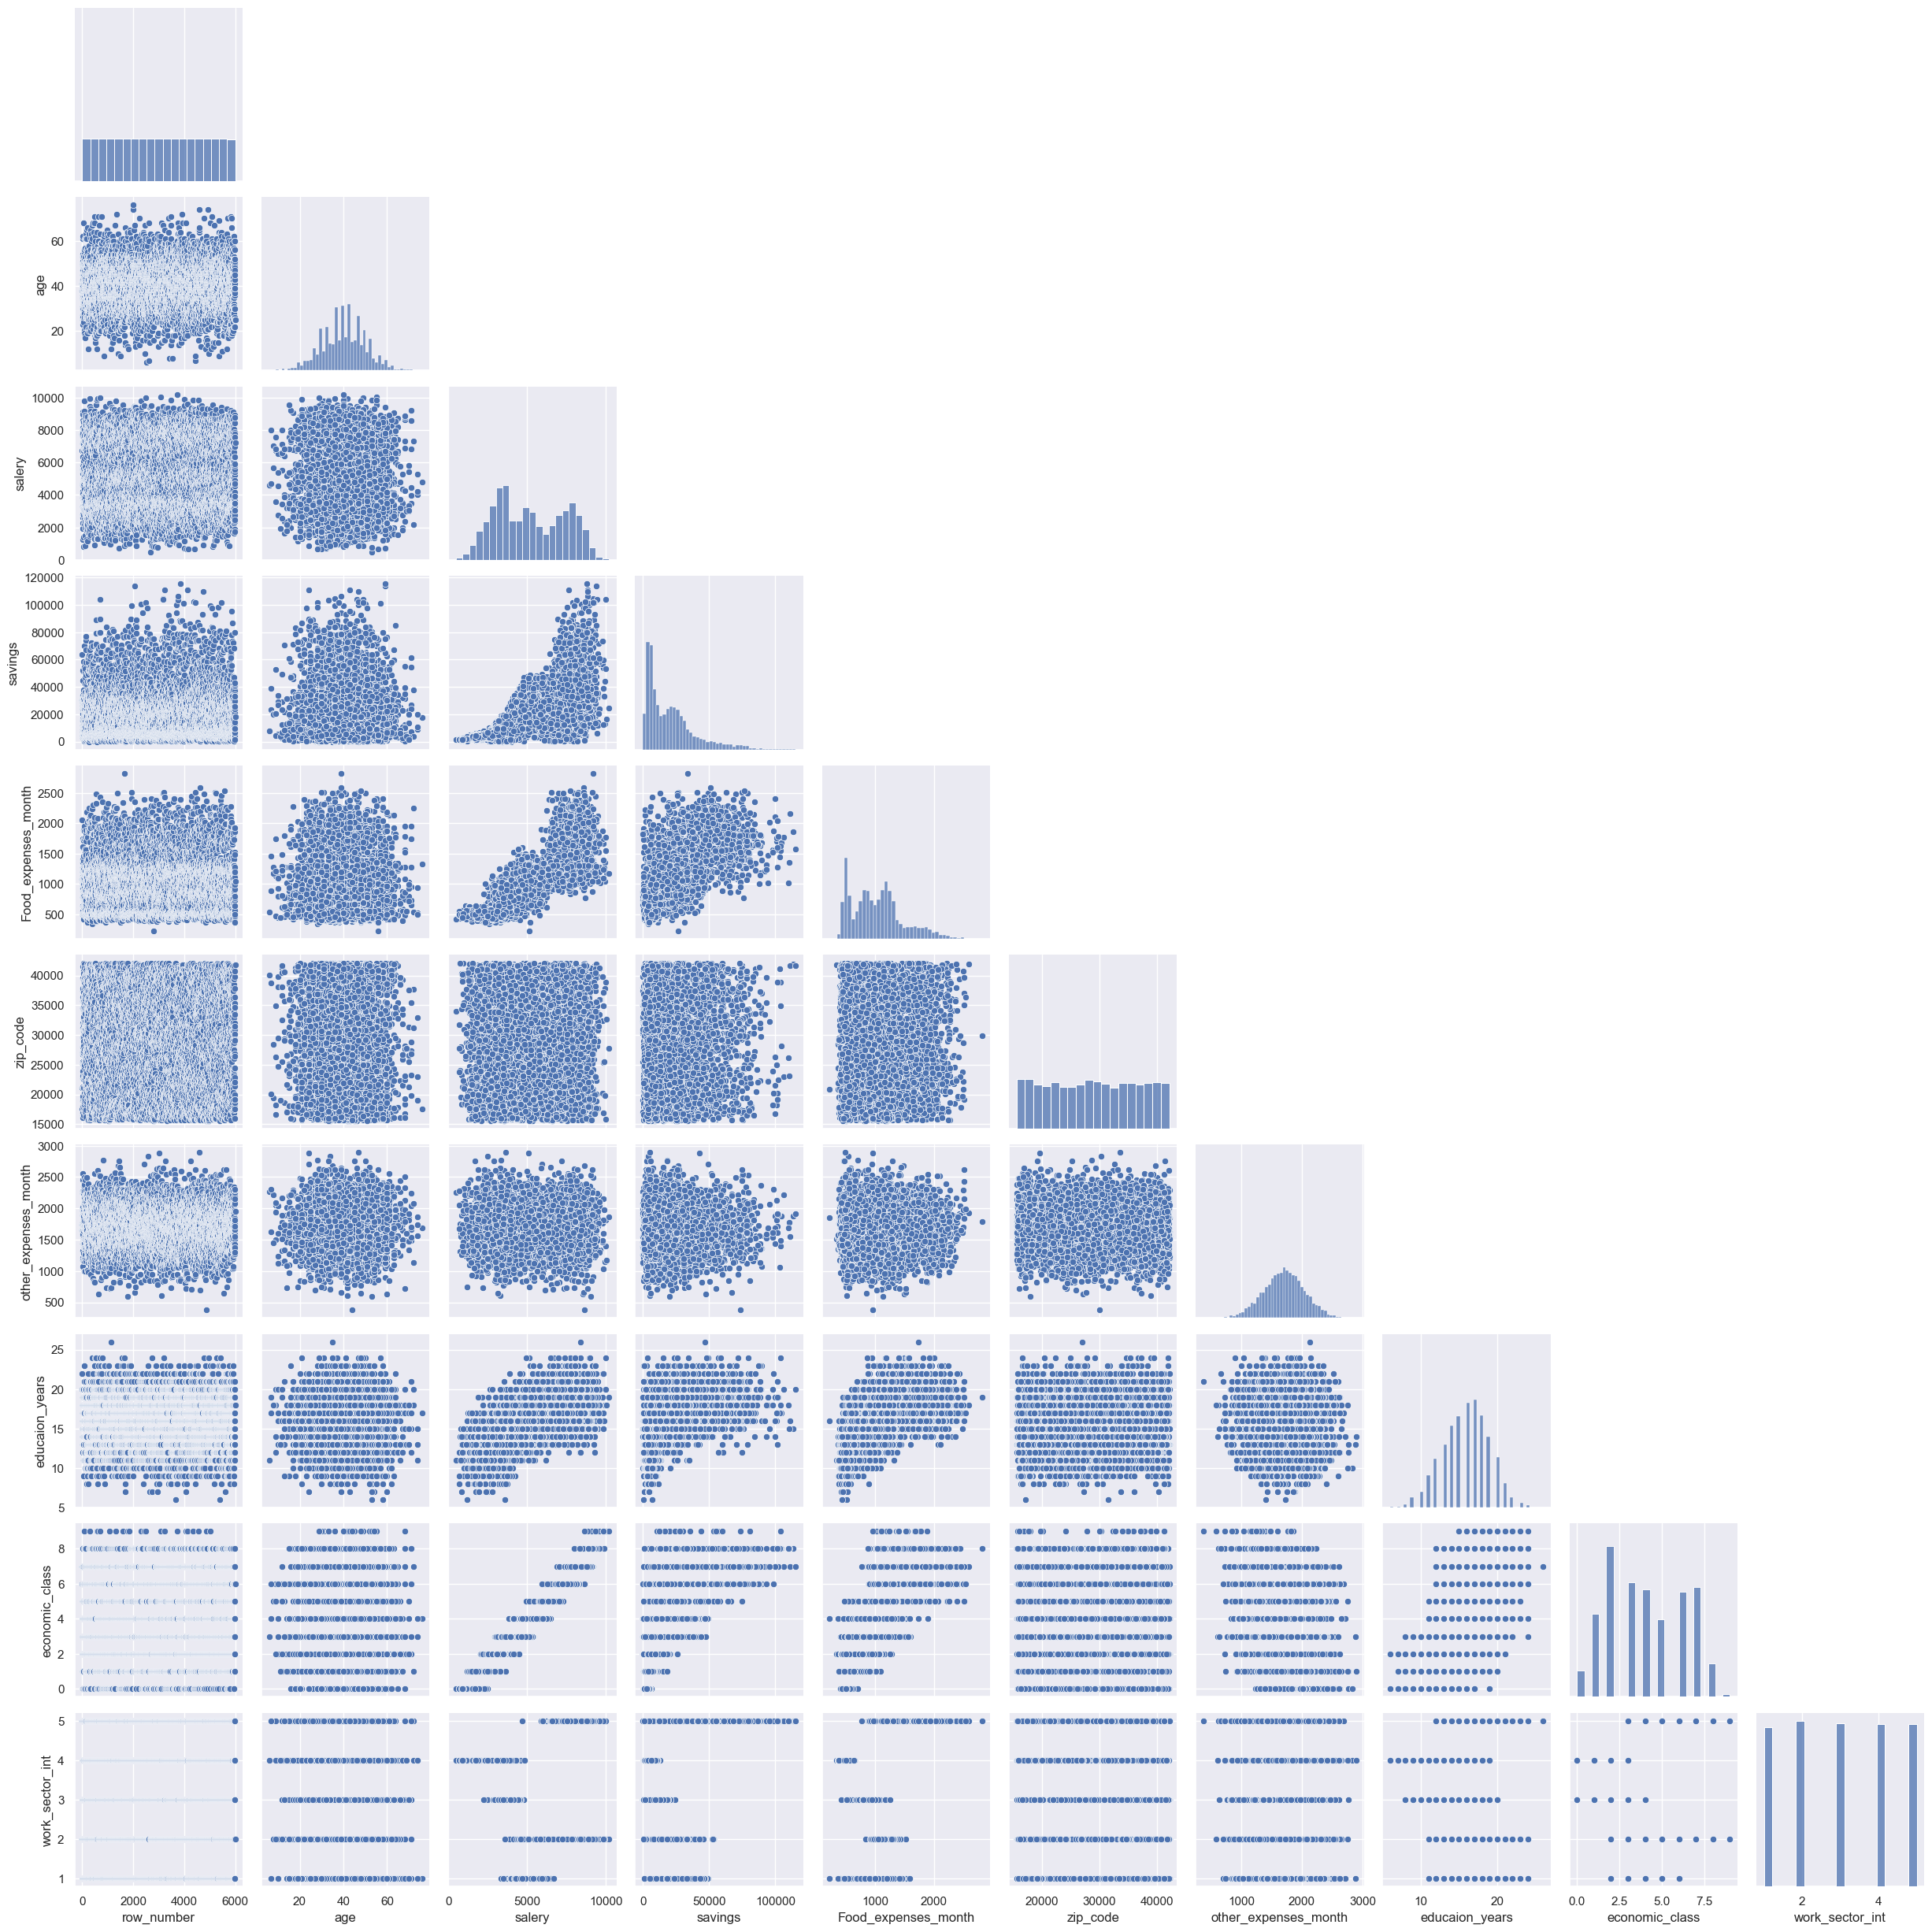

In [10]:
sns.pairplot(df.toPandas(), corner=True)

**בדיקה שאין שורות כפולות ללא עמודת מספר שורה**

In [11]:
df.toPandas().iloc[:, 1:].columns[df.toPandas().iloc[:, 1:].columns.duplicated()]

Index([], dtype='object')

נמצא שאין שורות כפולות

**יצירת דאטה חדש ללא ערכים ריקים לטובת בדיקת קורלציות מעמיקה יותר ובחינת אלגוריטמים לניבוי**

In [12]:
data = df.dropna()
data.toPandas().head()

row_number  age  salery  savings  Food_expenses_month  zip_code  \
0           1   38    6761    30433                 1089     21107   
1           2   41    7776    63653                 2057     17614   
2           3   47    4209    24310                  965     19128   
3           4   41    8142    29707                 1224     26651   
4           5   34    3845    25929                  903     16984   

   other_expenses_month  educaion_years  economic_class  work_sector_int  
0                  1652              20               6                2  
1                  1740              22               7                5  
2                  2030              18               3                1  
3                  1993              16               7                2  
4                  1073              17               3                1

In [13]:
data.toPandas().shape

(5958, 10)

ב41 שורות קיימים ערכים ריקים שנדרש להשלים 

In [14]:
CorrDF = data.sample(False, 1.0, 46)
vector_features = "features"
assembler = VectorAssembler(inputCols=CorrDF.columns, outputCol=vector_features)
df_vector = assembler.transform(data).select(vector_features)
matrix = Correlation.corr(df_vector, vector_features, 'pearson')
result = matrix.collect()[0]["pearson({})".format(vector_features)].values
reshape_matrix = pd.DataFrame(result.reshape(-1, len(CorrDF.columns)), columns=CorrDF.columns, index=CorrDF.columns)
reshape_matrix

row_number       age    salery   savings  \
row_number              1.000000  0.009201  0.013199  0.027646   
age                     0.009201  1.000000 -0.007864 -0.015662   
salery                  0.013199 -0.007864  1.000000  0.724992   
savings                 0.027646 -0.015662  0.724992  1.000000   
Food_expenses_month     0.016639 -0.011764  0.826750  0.702607   
zip_code               -0.016483  0.004224  0.007828  0.027261   
other_expenses_month   -0.002344  0.019489 -0.019530 -0.018821   
educaion_years          0.001050 -0.016125  0.665494  0.517332   
economic_class          0.013715 -0.010272  0.980104  0.712402   
work_sector_int         0.019816 -0.005140  0.089798  0.219052   

                      Food_expenses_month  zip_code  other_expenses_month  \
row_number                       0.016639 -0.016483             -0.002344   
age                             -0.011764  0.004224              0.019489   
salery                           0.826750  0.007828             -0.019530   
savings                          0.702607  0.027261             -0.018821   
Food_expenses_month              1.000000  0.009925             -0.016436   
zip_code                         0.009925  1.000000             -0.006570   
other_expenses_month            -0.016436 -0.006570              1.000000   
educaion_years                   0.625388  0.001970             -0.021489   
economic_class                   0.812136  0.011406             -0.167941   
work_sector_int                  0.219589 -0.005191             -0.004584   

                      educaion_years  economic_class  work_sector_int  
row_number                  0.001050        0.013715         0.019816  
age                        -0.016125       -0.010272        -0.005140  
salery                      0.665494        0.980104         0.089798  
savings                     0.517332        0.712402         0.219052  
Food_expenses_month         0.625388        0.812136         0.219589  
zip_code                    0.001970        0.011406        -0.005191  
other_expenses_month       -0.021489       -0.167941        -0.004584  
educaion_years              1.000000        0.653948        -0.047667  
economic_class              0.653948        1.000000         0.090557  
work_sector_int            -0.047667        0.090557         1.000000

<Axes: >

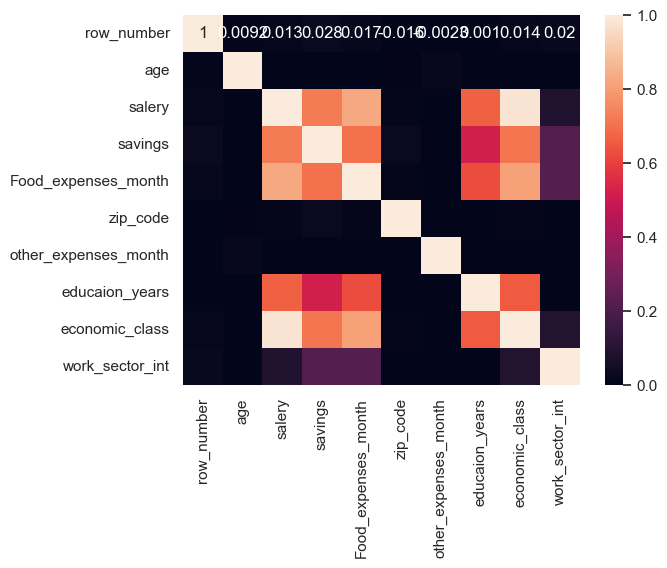

In [15]:
sns.heatmap(reshape_matrix, vmin=0, vmax=1, annot=True)

הגרף מספק מידע על חוזק הקשר בין כל שתי עמודות 

יש קשר חזק בצורה קצת חריגה בין משכורת לבין קבוצה כלכלית. ברמה הלוכית הקשר הזה הגיוני

קיים קשר חזק יחסית בין העמודות משכורת , חסכונות , הוצאות אוכל חודשיות , שנות לימוד וקבוצה כלכלית

בניגוד למחשבה הראשונית לגיל או להוצאות חודשיות נוספות אין קשר משמעותי כלשהו לאף שדה אחר

כמו שחשבתי למיקוד (אינדיקציה לכתובת) אין קשר משמעות לאף שדה אחר

לעמודת סקטור עבודה קיים קשר חלש לעמודות חסכונות , הוצאות אוכל חודשיות , משכות , קבוצה כלכלית

נשתמש בקשרים אלה בהמשך לטובת ניבוי והשלמת הערכים החסרים

**בדקתי באיזה שורות יש ערכים חסרים**

In [16]:
df.toPandas().isnull().sum()

row_number              10
age                      9
salery                  14
savings                  5
Food_expenses_month      5
zip_code                 5
other_expenses_month     5
educaion_years           5
economic_class          14
work_sector_int          9
dtype: int64

In [17]:
df.toPandas().isna().any(axis=1).sum()

41

In [18]:
df.toPandas().loc[df.toPandas().isnull().any(axis=1)]

row_number   age  salery   savings  Food_expenses_month  zip_code  \
6            7.0   NaN  2635.0    5849.0                553.0   37990.0   
42          43.0   NaN  5973.0   31330.0                626.0   24868.0   
125        126.0   NaN  3405.0    5569.0                573.0   18865.0   
222        223.0   NaN  5764.0   23506.0                620.0   20927.0   
340        341.0  31.0  9160.0   41704.0               1931.0   23503.0   
366        367.0  43.0  7026.0   69377.0               1597.0   19422.0   
405        406.0  40.0  6975.0   61187.0               1614.0   19296.0   
453        454.0  37.0  2652.0    5577.0                483.0   20115.0   
486        487.0  34.0     NaN   26150.0                789.0   16594.0   
528        529.0  36.0     NaN   23568.0               1238.0   32150.0   
571        572.0  47.0     NaN      32.0                827.0   30856.0   
613        614.0  51.0     NaN    4882.0                440.0   18475.0   
643        644.0  19.0     NaN   67694.0               1440.0   22082.0   
685        686.0  45.0     NaN    8873.0                690.0   35314.0   
730        731.0  59.0     NaN    6521.0                473.0   36777.0   
781        782.0  47.0     NaN   23969.0                831.0   32763.0   
811        812.0  44.0     NaN   30914.0               1176.0   38203.0   
2097      2098.0  13.0  1637.0    4058.0                464.0   29313.0   
2114      2115.0  50.0  1904.0    3087.0                621.0   41842.0   
2154      2155.0  32.0  5422.0   18345.0               1042.0   36782.0   
2169      2170.0  42.0  7881.0   24717.0               1085.0   28018.0   
2186      2187.0  26.0  4519.0   12041.0               1110.0   31038.0   
2227      2228.0  42.0  6354.0    8185.0               1186.0   41777.0   
2263      2264.0  45.0  3249.0    5114.0                618.0   29436.0   
2302      2303.0  50.0  8454.0  100861.0               1707.0   18279.0   
2311      2312.0  31.0  6105.0   39784.0               1269.0   32499.0   
2846         NaN  38.0  3716.0    9754.0                769.0   30386.0   
2876         NaN  46.0  3403.0   14770.0                691.0   16075.0   
2917         NaN  38.0  4097.0   32303.0               1096.0   41529.0   
4111      4112.0   NaN     NaN       NaN                  NaN       NaN   
5346      5347.0   NaN     NaN       NaN                  NaN       NaN   
5543      5545.0   NaN     NaN       NaN                  NaN       NaN   
5617      5619.0   NaN     NaN       NaN                  NaN       NaN   
5700      5702.0   NaN     NaN       NaN                  NaN       NaN   
5727         NaN  48.0  2340.0    4559.0                511.0   27226.0   
5763         NaN  13.0  3881.0    8187.0                624.0   40639.0   
5805         NaN  39.0  4920.0   14095.0               1036.0   34447.0   
5844         NaN  47.0  3418.0   10172.0                869.0   21917.0   
5880         NaN  33.0  3478.0    5406.0                679.0   29433.0   
5916         NaN  23.0  3164.0     315.0                835.0   16638.0   
5950         NaN  27.0  7354.0   12643.0               1468.0   21416.0   

      other_expenses_month  educaion_years  economic_class  work_sector_int  
6                   1595.0            13.0             2.0              4.0  
42                  1720.0            16.0             5.0              1.0  
125                 1947.0            15.0             2.0              3.0  
222                 1290.0            19.0             5.0              1.0  
340                 1814.0            21.0             8.0              NaN  
366                 1543.0            20.0             6.0              NaN  
405                 1732.0            19.0             6.0              NaN  
453                 2005.0            15.0             1.0              NaN  
486                 2553.0            21.0             3.0              1.0  
528                 2095.0            17.0             5.0              2.0

קיבלתי את הפירוט של כלל השורות עם עמודות חסרות 

**השלמתי את עמודת מספר שורה לפי המספר המקסימלי הקיים**

**לאחר מכן יצרתי עותק של הנתונים ללא מספר שורה לטובת המשך הניתוח**

In [19]:
max_row_number = df.select(F.max('row_number')).collect()[0][0]
df = df.withColumn("row_number", F.when(F.col("row_number").isNull(), max_row_number + 1).otherwise(F.col("row_number")))
df.toPandas().head()

row_number   age  salery  savings  Food_expenses_month  zip_code  \
0           1  38.0  6761.0  30433.0               1089.0   21107.0   
1           2  41.0  7776.0  63653.0               2057.0   17614.0   
2           3  47.0  4209.0  24310.0                965.0   19128.0   
3           4  41.0  8142.0  29707.0               1224.0   26651.0   
4           5  34.0  3845.0  25929.0                903.0   16984.0   

   other_expenses_month  educaion_years  economic_class  work_sector_int  
0                1652.0            20.0             6.0              2.0  
1                1740.0            22.0             7.0              5.0  
2                2030.0            18.0             3.0              1.0  
3                1993.0            16.0             7.0              2.0  
4                1073.0            17.0             3.0              1.0

In [20]:
df.toPandas().isnull().sum()

row_number               0
age                      9
salery                  14
savings                  5
Food_expenses_month      5
zip_code                 5
other_expenses_month     5
educaion_years           5
economic_class          14
work_sector_int          9
dtype: int64

In [21]:
dfc = df.drop('row_number')
dfc.toPandas().head()

age  salery  savings  Food_expenses_month  zip_code  other_expenses_month  \
0  38.0  6761.0  30433.0               1089.0   21107.0                1652.0   
1  41.0  7776.0  63653.0               2057.0   17614.0                1740.0   
2  47.0  4209.0  24310.0                965.0   19128.0                2030.0   
3  41.0  8142.0  29707.0               1224.0   26651.0                1993.0   
4  34.0  3845.0  25929.0                903.0   16984.0                1073.0   

   educaion_years  economic_class  work_sector_int  
0            20.0             6.0              2.0  
1            22.0             7.0              5.0  
2            18.0             3.0              1.0  
3            16.0             7.0              2.0  
4            17.0             3.0              1.0

In [22]:
dfc.toPandas().isnull().sum()

age                      9
salery                  14
savings                  5
Food_expenses_month      5
zip_code                 5
other_expenses_month     5
educaion_years           5
economic_class          14
work_sector_int          9
dtype: int64

In [23]:
dfc.toPandas().isna().any(axis=1).sum()

31

In [24]:
dfc.toPandas().loc[dfc.toPandas().isnull().any(axis=1)]

age  salery   savings  Food_expenses_month  zip_code  \
6      NaN  2635.0    5849.0                553.0   37990.0   
42     NaN  5973.0   31330.0                626.0   24868.0   
125    NaN  3405.0    5569.0                573.0   18865.0   
222    NaN  5764.0   23506.0                620.0   20927.0   
340   31.0  9160.0   41704.0               1931.0   23503.0   
366   43.0  7026.0   69377.0               1597.0   19422.0   
405   40.0  6975.0   61187.0               1614.0   19296.0   
453   37.0  2652.0    5577.0                483.0   20115.0   
486   34.0     NaN   26150.0                789.0   16594.0   
528   36.0     NaN   23568.0               1238.0   32150.0   
571   47.0     NaN      32.0                827.0   30856.0   
613   51.0     NaN    4882.0                440.0   18475.0   
643   19.0     NaN   67694.0               1440.0   22082.0   
685   45.0     NaN    8873.0                690.0   35314.0   
730   59.0     NaN    6521.0                473.0   36777.0   
781   47.0     NaN   23969.0                831.0   32763.0   
811   44.0     NaN   30914.0               1176.0   38203.0   
2097  13.0  1637.0    4058.0                464.0   29313.0   
2114  50.0  1904.0    3087.0                621.0   41842.0   
2154  32.0  5422.0   18345.0               1042.0   36782.0   
2169  42.0  7881.0   24717.0               1085.0   28018.0   
2186  26.0  4519.0   12041.0               1110.0   31038.0   
2227  42.0  6354.0    8185.0               1186.0   41777.0   
2263  45.0  3249.0    5114.0                618.0   29436.0   
2302  50.0  8454.0  100861.0               1707.0   18279.0   
2311  31.0  6105.0   39784.0               1269.0   32499.0   
4111   NaN     NaN       NaN                  NaN       NaN   
5346   NaN     NaN       NaN                  NaN       NaN   
5543   NaN     NaN       NaN                  NaN       NaN   
5617   NaN     NaN       NaN                  NaN       NaN   
5700   NaN     NaN       NaN                  NaN       NaN   

      other_expenses_month  educaion_years  economic_class  work_sector_int  
6                   1595.0            13.0             2.0              4.0  
42                  1720.0            16.0             5.0              1.0  
125                 1947.0            15.0             2.0              3.0  
222                 1290.0            19.0             5.0              1.0  
340                 1814.0            21.0             8.0              NaN  
366                 1543.0            20.0             6.0              NaN  
405                 1732.0            19.0             6.0              NaN  
453                 2005.0            15.0             1.0              NaN  
486                 2553.0            21.0             3.0              1.0  
528                 2095.0            17.0             5.0              2.0  
571                 2082.0            10.0             2.0              3.0  
613                 1331.0            12.0             1.0              4.0  
643                 1523.0            19.0             6.0              5.0  
685                 2517.0            16.0             2.0              3.0  
730                 1543.0            13.0             2.0              4.0  
781                 2035.0            17.0             4.0              1.0  
811                 2006.0            19.0             4.0              1.0  
2097                1167.0            13.0             NaN              4.0  
2114                1913.0            15.0             NaN              4.0  
2154                1215.0            15.0             NaN              1.0  
2169                1644.0            19.0             NaN              2.0  
2186                1387.0            18.0             NaN              1.0  
2227                1838.0            19.0             NaN              2.0  
2263                1737.0            12.0             NaN              4.0  
2302                1820.0            16

**הורדתי שורות בהם כל הערכים ריקים**

In [25]:
dfc = dfc.dropna(how='all')
dfc.toPandas().isnull().sum()

age                     4
salery                  9
savings                 0
Food_expenses_month     0
zip_code                0
other_expenses_month    0
educaion_years          0
economic_class          9
work_sector_int         4
dtype: int64

In [26]:
dfc.toPandas().isna().any(axis=1).sum()

26

In [27]:
dfc.toPandas().loc[dfc.toPandas().isnull().any(axis=1)]

age  salery  savings  Food_expenses_month  zip_code  \
6      NaN  2635.0     5849                  553     37990   
42     NaN  5973.0    31330                  626     24868   
125    NaN  3405.0     5569                  573     18865   
222    NaN  5764.0    23506                  620     20927   
340   31.0  9160.0    41704                 1931     23503   
366   43.0  7026.0    69377                 1597     19422   
405   40.0  6975.0    61187                 1614     19296   
453   37.0  2652.0     5577                  483     20115   
486   34.0     NaN    26150                  789     16594   
528   36.0     NaN    23568                 1238     32150   
571   47.0     NaN       32                  827     30856   
613   51.0     NaN     4882                  440     18475   
643   19.0     NaN    67694                 1440     22082   
685   45.0     NaN     8873                  690     35314   
730   59.0     NaN     6521                  473     36777   
781   47.0     NaN    23969                  831     32763   
811   44.0     NaN    30914                 1176     38203   
2097  13.0  1637.0     4058                  464     29313   
2114  50.0  1904.0     3087                  621     41842   
2154  32.0  5422.0    18345                 1042     36782   
2169  42.0  7881.0    24717                 1085     28018   
2186  26.0  4519.0    12041                 1110     31038   
2227  42.0  6354.0     8185                 1186     41777   
2263  45.0  3249.0     5114                  618     29436   
2302  50.0  8454.0   100861                 1707     18279   
2311  31.0  6105.0    39784                 1269     32499   

      other_expenses_month  educaion_years  economic_class  work_sector_int  
6                     1595              13             2.0              4.0  
42                    1720              16             5.0              1.0  
125                   1947              15             2.0              3.0  
222                   1290              19             5.0              1.0  
340                   1814              21             8.0              NaN  
366                   1543              20             6.0              NaN  
405                   1732              19             6.0              NaN  
453                   2005              15             1.0              NaN  
486                   2553              21             3.0              1.0  
528                   2095              17             5.0              2.0  
571                   2082              10             2.0              3.0  
613                   1331              12             1.0              4.0  
643                   1523              19             6.0              5.0  
685                   2517              16             2.0              3.0  
730                   1543              13             2.0              4.0  
781                   2035              17             4.0              1.0  
811                   2006              19             4.0              1.0  
2097                  1167              13             NaN              4.0  
2114                  1913              15             NaN              4.0  
2154                  1215              15             NaN              1.0  
2169                  1644              19             NaN              2.0  
2186                  1387              18             NaN              1.0  
2227                  1838              19             NaN              2.0  
2263                  1737              12             NaN              4.0  
2302                  1820              16             NaN              5.0  
2311                  1898              15             NaN              1.0

לאחר בדיקה עולה כי בכל אחת מהשרות עם נתון חסר - חסר רק נתון אחד

**השלמת ערכי המשכורת החסרים**

 היות ופיזור המשכורות מאוד רחב לא סביר להריץ מודל רנדום פורסט

אחרי מספר בדיקות החלטתי לקחת משכורת ממוצעת לפי קבוצה כלכלית וסקטור עבודה שהם שדות עם מספר ערכים אפשרים קטן יחסית ועם קשר לשדה המשכורת 

In [28]:
mean_salaries = dfc.groupBy("economic_class", "work_sector_int") \
    .agg(avg(when(col("salery").isNull(), None).otherwise(col("salery"))).alias("mean_salary_group"))
dfc = dfc.join(mean_salaries, on=["economic_class", "work_sector_int"], how="left")
dfc = dfc.withColumn("salery", when(col("salery").isNull(), col("mean_salary_group")).otherwise(col("salery")))
dfc = dfc.drop("mean_salary_group")
dfc.toPandas().head()

economic_class  work_sector_int   age  salery  savings  \
0             6.0              2.0  38.0  6761.0    30433   
1             7.0              5.0  41.0  7776.0    63653   
2             3.0              1.0  47.0  4209.0    24310   
3             7.0              2.0  41.0  8142.0    29707   
4             3.0              1.0  34.0  3845.0    25929   

   Food_expenses_month  zip_code  other_expenses_month  educaion_years  
0                 1089     21107                  1652              20  
1                 2057     17614                  1740              22  
2                  965     19128                  2030              18  
3                 1224     26651                  1993              16  
4                  903     16984                  1073              17

In [29]:
dfc.toPandas().isnull().sum()

economic_class          9
work_sector_int         4
age                     4
salery                  0
savings                 0
Food_expenses_month     0
zip_code                0
other_expenses_month    0
educaion_years          0
dtype: int64

In [30]:
dfc.toPandas().isna().any(axis=1).sum()

17

In [31]:
dfc.toPandas().loc[dfc.toPandas().isnull().any(axis=1)]

economic_class  work_sector_int   age  salery  savings  \
6                2.0              4.0   NaN  2635.0     5849   
42               5.0              1.0   NaN  5973.0    31330   
125              2.0              3.0   NaN  3405.0     5569   
222              5.0              1.0   NaN  5764.0    23506   
340              8.0              NaN  31.0  9160.0    41704   
366              6.0              NaN  43.0  7026.0    69377   
405              6.0              NaN  40.0  6975.0    61187   
453              1.0              NaN  37.0  2652.0     5577   
2097             NaN              4.0  13.0  1637.0     4058   
2114             NaN              4.0  50.0  1904.0     3087   
2154             NaN              1.0  32.0  5422.0    18345   
2169             NaN              2.0  42.0  7881.0    24717   
2186             NaN              1.0  26.0  4519.0    12041   
2227             NaN              2.0  42.0  6354.0     8185   
2263             NaN              4.0  45.0  3249.0     5114   
2302             NaN              5.0  50.0  8454.0   100861   
2311             NaN              1.0  31.0  6105.0    39784   

      Food_expenses_month  zip_code  other_expenses_month  educaion_years  
6                     553     37990                  1595              13  
42                    626     24868                  1720              16  
125                   573     18865                  1947              15  
222                   620     20927                  1290              19  
340                  1931     23503                  1814              21  
366                  1597     19422                  1543              20  
405                  1614     19296                  1732              19  
453                   483     20115                  2005              15  
2097                  464     29313                  1167              13  
2114                  621     41842                  1913              15  
2154                 1042     36782                  1215              15  
2169                 1085     28018                  1644              19  
2186                 1110     31038                  1387              18  
2227                 1186     41777                  1838              19  
2263                  618     29436                  1737              12  
2302                 1707     18279                  1820              16  
2311                 1269     32499                  1898              15

**השלמת ערכים חסרים בעמודת גיל**

בנוסף לערכים החסרים בעמודת הגיל יש עוד שני מצבים חריגים בהם נידרש לטפל 

גיל עובד קטן מ 14 (הגיל הנמוך ביותר עבור נערים העובדים בעולם) ולכן התיחסתי אליו כאל ערך ריק

גיל עובד הקטן ממספר שנות הלימוד של העובד פלוס 4 (התחלת הלימודים גם במיקרים קיצוניים) גם התיחסתי אליו כערך ריק

כמו שצוין אין קשר בין הגיל לעמודות נוספות שיכולות לנבא את הערכים החסרים 

מניתוח שדה הגיל עולה כי הממצוע והחציון זהים ולכן בחרתי בהם כדי להשלים את הערכים החסרים

In [32]:
age_median = dfc.approxQuantile("age", [0.5], 0.0)[0]
dfc = dfc.withColumn(
    "age", 
    when((col("age").isNull()) | (col("age") < 14) | (col("age") <= col("educaion_years") + 4), age_median).otherwise(col("age"))
)
dfc.toPandas().head()

economic_class  work_sector_int   age  salery  savings  \
0             6.0              2.0  38.0  6761.0    30433   
1             7.0              5.0  41.0  7776.0    63653   
2             3.0              1.0  47.0  4209.0    24310   
3             7.0              2.0  41.0  8142.0    29707   
4             3.0              1.0  34.0  3845.0    25929   

   Food_expenses_month  zip_code  other_expenses_month  educaion_years  
0                 1089     21107                  1652              20  
1                 2057     17614                  1740              22  
2                  965     19128                  2030              18  
3                 1224     26651                  1993              16  
4                  903     16984                  1073              17

In [33]:
dfc.toPandas().isnull().sum()

economic_class          9
work_sector_int         4
age                     0
salery                  0
savings                 0
Food_expenses_month     0
zip_code                0
other_expenses_month    0
educaion_years          0
dtype: int64

In [34]:
dfc.toPandas().isna().any(axis=1).sum()

13

In [35]:
dfc.toPandas().loc[dfc.toPandas().isnull().any(axis=1)]

economic_class  work_sector_int   age  salery  savings  \
340              8.0              NaN  31.0  9160.0    41704   
366              6.0              NaN  43.0  7026.0    69377   
405              6.0              NaN  40.0  6975.0    61187   
453              1.0              NaN  37.0  2652.0     5577   
2097             NaN              4.0  40.0  1637.0     4058   
2114             NaN              4.0  50.0  1904.0     3087   
2154             NaN              1.0  32.0  5422.0    18345   
2169             NaN              2.0  42.0  7881.0    24717   
2186             NaN              1.0  26.0  4519.0    12041   
2227             NaN              2.0  42.0  6354.0     8185   
2263             NaN              4.0  45.0  3249.0     5114   
2302             NaN              5.0  50.0  8454.0   100861   
2311             NaN              1.0  31.0  6105.0    39784   

      Food_expenses_month  zip_code  other_expenses_month  educaion_years  
340                  1931     23503                  1814              21  
366                  1597     19422                  1543              20  
405                  1614     19296                  1732              19  
453                   483     20115                  2005              15  
2097                  464     29313                  1167              13  
2114                  621     41842                  1913              15  
2154                 1042     36782                  1215              15  
2169                 1085     28018                  1644              19  
2186                 1110     31038                  1387              18  
2227                 1186     41777                  1838              19  
2263                  618     29436                  1737              12  
2302                 1707     18279                  1820              16  
2311                 1269     32499                  1898              15

**השלמת ערכים ריקים בסקטור עבודה**

היות ומדובר בשדה קטגוריאלי עם מספר ערכים מצומצם 

בחירת איזה מודל הכי מתאים להשלמת הנתונים

יצירת וקטור נתונים עבור סקטור עבודה

In [36]:
feature_columns_ws = ['economic_class','age', 'salery', 'savings', 'Food_expenses_month', 'zip_code', 'other_expenses_month',
                      'educaion_years']
assembler = VectorAssembler(inputCols=feature_columns_ws, outputCol="features_ws")
data_vector_ws = assembler.transform(data)
data_vector_ws.toPandas().head()

row_number  age  salery  savings  Food_expenses_month  zip_code  \
0           1   38    6761    30433                 1089     21107   
1           2   41    7776    63653                 2057     17614   
2           3   47    4209    24310                  965     19128   
3           4   41    8142    29707                 1224     26651   
4           5   34    3845    25929                  903     16984   

   other_expenses_month  educaion_years  economic_class  work_sector_int  \
0                  1652              20               6                2   
1                  1740              22               7                5   
2                  2030              18               3                1   
3                  1993              16               7                2   
4                  1073              17               3                1   

                                         features_ws  
0  [6.0, 38.0, 6761.0, 30433.0, 1089.0, 21107.0, ...  
1  [7.0, 41.0, 7776.0, 63653.0, 2057.0, 17614.0, ...  
2  [3.0, 47.0, 4209.0, 24310.0, 965.0, 19128.0, 2...  
3  [7.0, 41.0, 8142.0, 29707.0, 1224.0, 26651.0, ...  
4  [3.0, 34.0, 3845.0, 25929.0, 903.0, 16984.0, 1...

יחס לימוד לאומת מבחן מצב אקונומי

In [37]:
(train_ws, test_ws) = data_vector_ws.randomSplit([0.8,0.2], seed =2020)
print("train #: " + str(train_ws.count()),"test#: " + str(test_ws.count()))

train #: 4793 test#: 1165


Decision Tree - work_sector_int

In [38]:
from pyspark.ml.classification import DecisionTreeClassifier
dt_ws = DecisionTreeClassifier(featuresCol='features_ws', labelCol='work_sector_int', maxDepth=3)
dtModel_ws = dt_ws.fit(train_ws)
dt_predictions_ws = dtModel_ws.transform(test_ws)
dt_predictions_ws.toPandas().head()

row_number  age  salery  savings  Food_expenses_month  zip_code  \
0          10   40    4070    15272                 1013     31931   
1          14   27    8963    44904                 1602     34444   
2          18   38    4586    28820                  932     25154   
3          21   51    8581    52042                 1616     23910   
4          22   62    5346    26391                 1280     16147   

   other_expenses_month  educaion_years  economic_class  work_sector_int  \
0                  1971              17               3                1   
1                  1681              16               8                5   
2                  1212              15               4                1   
3                  1994              18               7                5   
4                  2236              18               4                1   

                                         features_ws  \
0  [3.0, 40.0, 4070.0, 15272.0, 1013.0, 31931.0, ...   
1  [8.0, 27.0, 8963.0, 44904.0, 1602.0, 34444.0, ...   
2  [4.0, 38.0, 4586.0, 28820.0, 932.0, 25154.0, 1...   
3  [7.0, 51.0, 8581.0, 52042.0, 1616.0, 23910.0, ...   
4  [4.0, 62.0, 5346.0, 26391.0, 1280.0, 16147.0, ...   

                         rawPrediction  \
0    [0.0, 11.0, 2.0, 851.0, 4.0, 0.0]   
1    [0.0, 1.0, 53.0, 0.0, 0.0, 797.0]   
2  [0.0, 852.0, 149.0, 37.0, 9.0, 2.0]   
3    [0.0, 1.0, 53.0, 0.0, 0.0, 797.0]   
4  [0.0, 852.0, 149.0, 37.0, 9.0, 2.0]   

                                         probability  prediction  
0  [0.0, 0.012672811059907835, 0.0023041474654377...         3.0  
1  [0.0, 0.0011750881316098707, 0.062279670975323...         5.0  
2  [0.0, 0.8122020972354623, 0.14204003813155386,...         1.0  
3  [0.0, 0.0011750881316098707, 0.062279670975323...         5.0  
4  [0.0, 0.8122020972354623, 0.14204003813155386,...         1.0

In [39]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
AccuracyDT_ws = MulticlassClassificationEvaluator(labelCol = 'work_sector_int', metricName = 'accuracy')
print(' DT Accuracy:', AccuracyDT_ws.evaluate(dt_predictions_ws))

 DT Accuracy: 0.8927038626609443


In [40]:
importances_dt_ws = dtModel_ws.featureImportances
importances_list_dt_ws = importances_dt_ws.toArray().tolist()
feature_importances_dt_ws = list(zip(feature_columns_ws, importances_list_dt_ws))
feature_importances_dt_ws.sort(key=lambda x: x[1], reverse=True)
print("Feature Importances:")
for feature, importance in feature_importances_dt_ws:
    print(f"{feature}: {importance}")

Feature Importances:
salery: 0.5273655650777788
Food_expenses_month: 0.44719531612708857
savings: 0.02543911879513266
economic_class: 0.0
age: 0.0
zip_code: 0.0
other_expenses_month: 0.0
educaion_years: 0.0


In [41]:
model_ws = dt_ws.fit(data_vector_ws)
predictions_ws = model_ws.transform(data_vector_ws)
predictions_ws.select(['work_sector_int','age', 'salery', 'savings', 'Food_expenses_month', 'zip_code', 'other_expenses_month', 'educaion_years', 'economic_class']).toPandas().head()

work_sector_int  age  salery  savings  Food_expenses_month  zip_code  \
0                2   38    6761    30433                 1089     21107   
1                5   41    7776    63653                 2057     17614   
2                1   47    4209    24310                  965     19128   
3                2   41    8142    29707                 1224     26651   
4                1   34    3845    25929                  903     16984   

   other_expenses_month  educaion_years  economic_class  
0                  1652              20               6  
1                  1740              22               7  
2                  2030              18               3  
3                  1993              16               7  
4                  1073              17               3

In [42]:
y_t_DT_ws= predictions_ws.select(['work_sector_int']).collect()
y_predictions_DT_ws = predictions_ws.select(['prediction']).collect()
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_t_DT_ws, y_predictions_DT_ws))
print(confusion_matrix(y_t_DT_ws, y_predictions_DT_ws))

              precision    recall  f1-score   support

           1       0.81      0.96      0.88      1162
           2       0.82      0.79      0.80      1215
           3       0.98      0.88      0.93      1192
           4       0.93      0.99      0.96      1192
           5       0.95      0.84      0.89      1197

    accuracy                           0.89      5958
   macro avg       0.90      0.89      0.89      5958
weighted avg       0.90      0.89      0.89      5958

[[1116   26   17    3    0]
 [ 199  958    2    0   56]
 [  56    0 1052   84    0]
 [   8    0    7 1177    0]
 [   3  186    0    0 1008]]


התבוססת מאוד על עמודת משכורת צריך לקחת בחשבון את זה הגיוני אבל צריך לקחת בחשבון

ניתן לראות שהניבוי נעשה בצורה יחסית טובה 89% הצלחה

הסקטור עם האוז הצלחה הכי נמוך הוא סקטור 1 עם 81% אך עדיין טוב

Logistic Regression - work_sector_int

In [43]:
from pyspark.ml.classification import LogisticRegression
lr_ws = LogisticRegression(featuresCol = 'features_ws', labelCol = 'work_sector_int', maxIter=10)
lrModel_ws = lr_ws.fit(train_ws)
lr_predictions_ws = lrModel_ws.transform(test_ws)
lr_predictions_ws.toPandas().head()

row_number  age  salery  savings  Food_expenses_month  zip_code  \
0          10   40    4070    15272                 1013     31931   
1          14   27    8963    44904                 1602     34444   
2          18   38    4586    28820                  932     25154   
3          21   51    8581    52042                 1616     23910   
4          22   62    5346    26391                 1280     16147   

   other_expenses_month  educaion_years  economic_class  work_sector_int  \
0                  1971              17               3                1   
1                  1681              16               8                5   
2                  1212              15               4                1   
3                  1994              18               7                5   
4                  2236              18               4                1   

                                         features_ws  \
0  [3.0, 40.0, 4070.0, 15272.0, 1013.0, 31931.0, ...   
1  [8.0, 27.0, 8963.0, 44904.0, 1602.0, 34444.0, ...   
2  [4.0, 38.0, 4586.0, 28820.0, 932.0, 25154.0, 1...   
3  [7.0, 51.0, 8581.0, 52042.0, 1616.0, 23910.0, ...   
4  [4.0, 62.0, 5346.0, 26391.0, 1280.0, 16147.0, ...   

                                       rawPrediction  \
0  [-5.735908353467685, 6.536539503487445, 2.5794...   
1  [-5.72950240077041, 6.975602658186852, 17.9575...   
2  [-5.733824960247319, 8.641554404345381, 2.3174...   
3  [-5.729573739264503, 8.581147798532028, 16.429...   
4  [-5.733719331770602, 7.2554239921927905, 6.560...   

                                         probability  prediction  
0  [3.2701053208199915e-06, 0.6989049622650865, 0...         1.0  
1  [7.394582365201489e-14, 2.4359629010241467e-08...         5.0  
2  [5.692388247488901e-07, 0.9964200243108433, 0....         1.0  
3  [7.930480544149536e-14, 1.301268449195165e-07,...         5.0  
4  [1.4899043759075992e-06, 0.6520361372598859, 0...         1.0

In [44]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
AccuracyDT_ws = MulticlassClassificationEvaluator(labelCol = 'work_sector_int', metricName = 'accuracy')
print('LG Accuracy:', AccuracyDT_ws.evaluate(lr_predictions_ws))

LG Accuracy: 0.9184549356223176


In [45]:
y_t_LR_ws = lr_predictions_ws.select(['work_sector_int']).collect()
y_predictions_LR_ws = lr_predictions_ws.select(['prediction']).collect()
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_t_LR_ws, y_predictions_LR_ws))
print(confusion_matrix(y_t_LR_ws, y_predictions_LR_ws))

              precision    recall  f1-score   support

           1       0.91      0.87      0.89       216
           2       0.82      0.90      0.86       227
           3       0.94      0.93      0.94       212
           4       0.97      0.98      0.98       246
           5       0.95      0.91      0.93       264

    accuracy                           0.92      1165
   macro avg       0.92      0.92      0.92      1165
weighted avg       0.92      0.92      0.92      1165

[[187  20   8   0   1]
 [ 11 204   0   0  12]
 [  7   0 197   8   0]
 [  0   0   4 242   0]
 [  0  24   0   0 240]]


ניתן לראות שהניבוי נעשה בצורה יחסית טובה 91% הצלחה

הסקטור עם האוז הצלחה הכי נמוך הוא סקטור 2 עם 82% אך עדיין טוב

Random Forest - work_sector_int

In [46]:
from pyspark.ml.classification import RandomForestClassifier
RF_ws = RandomForestClassifier(featuresCol = 'features_ws', labelCol = 'work_sector_int')
RFModel_ws = RF_ws.fit(train_ws)
RF_predictions_ws = RFModel_ws.transform(test_ws)
RF_predictions_ws.toPandas().head()

row_number  age  salery  savings  Food_expenses_month  zip_code  \
0          10   40    4070    15272                 1013     31931   
1          14   27    8963    44904                 1602     34444   
2          18   38    4586    28820                  932     25154   
3          21   51    8581    52042                 1616     23910   
4          22   62    5346    26391                 1280     16147   

   other_expenses_month  educaion_years  economic_class  work_sector_int  \
0                  1971              17               3                1   
1                  1681              16               8                5   
2                  1212              15               4                1   
3                  1994              18               7                5   
4                  2236              18               4                1   

                                         features_ws  \
0  [3.0, 40.0, 4070.0, 15272.0, 1013.0, 31931.0, ...   
1  [8.0, 27.0, 8963.0, 44904.0, 1602.0, 34444.0, ...   
2  [4.0, 38.0, 4586.0, 28820.0, 932.0, 25154.0, 1...   
3  [7.0, 51.0, 8581.0, 52042.0, 1616.0, 23910.0, ...   
4  [4.0, 62.0, 5346.0, 26391.0, 1280.0, 16147.0, ...   

                                       rawPrediction  \
0  [0.0, 7.807744597405724, 0.8628194299612615, 1...   
1  [0.0, 0.08251471003148529, 0.9644375224202107,...   
2  [0.0, 17.288323613663454, 1.869787350361533, 0...   
3  [0.0, 0.05770097316675376, 0.8265480056901693,...   
4  [0.0, 16.289285304276632, 3.232225131140469, 0...   

                                         probability  prediction  
0  [0.0, 0.3903872298702861, 0.04314097149806306,...         3.0  
1  [0.0, 0.004125735501574265, 0.0482218761210105...         5.0  
2  [0.0, 0.8644161806831727, 0.09348936751807665,...         1.0  
3  [0.0, 0.0028850486583376876, 0.041327400284508...         5.0  
4  [0.0, 0.8144642652138318, 0.16161125655702346,...         1.0

In [47]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
AccuracyRF_ws = MulticlassClassificationEvaluator(labelCol = 'work_sector_int', metricName = 'accuracy')
print(' RF Accuracy:', AccuracyRF_ws.evaluate(RF_predictions_ws))

 RF Accuracy: 0.9253218884120171


In [48]:
importances_RF_ws = RFModel_ws.featureImportances
importances_list_RF_ws = importances_RF_ws.toArray().tolist()
feature_importances_RF_ws = list(zip(feature_columns_ws, importances_list_RF_ws))
feature_importances_RF_ws.sort(key=lambda x: x[1], reverse=True)
print("Feature Importances:")
for feature, importance in feature_importances_RF_ws:
    print(f"{feature}: {importance}")

Feature Importances:
Food_expenses_month: 0.3864903096817395
salery: 0.3432890648118089
savings: 0.12552959488809912
economic_class: 0.12481620712795367
educaion_years: 0.017230931617148053
other_expenses_month: 0.0010380289881791794
age: 0.0008243705030280101
zip_code: 0.0007814923820436883


In [49]:
y_t_RF_ws = RF_predictions_ws.select(['work_sector_int']).collect()
y_predictions_RF_ws = RF_predictions_ws.select(['prediction']).collect()
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_t_RF_ws, y_predictions_RF_ws))
print(confusion_matrix(y_t_RF_ws, y_predictions_RF_ws))

              precision    recall  f1-score   support

           1       0.86      0.91      0.88       216
           2       0.89      0.86      0.87       227
           3       0.93      0.93      0.93       212
           4       0.97      0.98      0.97       246
           5       0.97      0.94      0.95       264

    accuracy                           0.93      1165
   macro avg       0.92      0.92      0.92      1165
weighted avg       0.93      0.93      0.93      1165

[[197   9   9   0   1]
 [ 25 195   0   0   7]
 [  7   0 198   7   0]
 [  1   0   5 240   0]
 [  0  16   0   0 248]]


ניתן לראות שהניבוי נעשה בצורה יחסית טובה 91% הצלחה

הסקטור עם האוז הצלחה הכי נמוך הוא סקטור 1 עם 86% אך עדיין טוב

לכן בחרתי להשתמש ב רנדום פורסט לצורך ניבוי עמודת סקטור עבודה עם הסיכוי הגבוה ביותר להצלחה

In [50]:
from pyspark.ml.classification import RandomForestClassifier

impute_values = dfc.select(
    [mean(col(column)).alias(column) for column in dfc.columns if column != "work_sector_int"]
).collect()[0].asDict()

train_data = dfc.filter(col("work_sector_int").isNotNull())
test_data = dfc.filter(col("work_sector_int").isNull())

assembler = VectorAssembler(
    inputCols=["educaion_years", "economic_class", "age", "salery", "savings", "Food_expenses_month", "zip_code", "other_expenses_month"],
    outputCol="features",
    handleInvalid="skip"
)

train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

RF = RandomForestClassifier(featuresCol="features", labelCol="work_sector_int")
RFModel = RF.fit(train_data)

RF_predictions = RFModel.transform(test_data)
RF_predictions.toPandas().head()

economic_class  work_sector_int   age  salery  savings  \
0               8              NaN  31.0  9160.0    41704   
1               6              NaN  43.0  7026.0    69377   
2               6              NaN  40.0  6975.0    61187   
3               1              NaN  37.0  2652.0     5577   

   Food_expenses_month  zip_code  other_expenses_month  educaion_years  \
0                 1931     23503                  1814              21   
1                 1597     19422                  1543              20   
2                 1614     19296                  1732              19   
3                  483     20115                  2005              15   

                                            features  \
0  [21.0, 8.0, 31.0, 9160.0, 41704.0, 1931.0, 235...   
1  [20.0, 6.0, 43.0, 7026.0, 69377.0, 1597.0, 194...   
2  [19.0, 6.0, 40.0, 6975.0, 61187.0, 1614.0, 192...   
3  [15.0, 1.0, 37.0, 2652.0, 5577.0, 483.0, 20115...   

                                       rawPrediction  \
0  [0.0, 0.06447590787004885, 0.8139388704637757,...   
1  [0.0, 0.07192747269866286, 1.0633521684160259,...   
2  [0.0, 0.07192747269866286, 1.0633521684160259,...   
3  [0.0, 0.002756402127702175, 0.0, 0.54304415312...   

                                         probability  prediction  
0  [0.0, 0.003223795393502442, 0.0406969435231887...         5.0  
1  [0.0, 0.003596373634933143, 0.0531676084208012...         5.0  
2  [0.0, 0.003596373634933143, 0.0531676084208012...         5.0  
3  [0.0, 0.0001378201063851088, 0.0, 0.0271522076...         4.0

In [51]:
dfc = dfc.join(RF_predictions.select("educaion_years",
                                     "economic_class",
                                     "age", "salery", "savings", "Food_expenses_month", "zip_code", "other_expenses_month", "prediction"), 
                                on=["educaion_years",
                                    "economic_class", "age", "salery", "savings", "Food_expenses_month", "zip_code", "other_expenses_month"], 
                                how="left")
dfc = dfc.withColumn("work_sector_int", coalesce(col("work_sector_int"), col("prediction"))).drop("prediction")
dfc.toPandas().head()

educaion_years  economic_class   age  salery  savings  Food_expenses_month  \
0              20             6.0  38.0  6761.0    30433                 1089   
1              22             7.0  41.0  7776.0    63653                 2057   
2              18             3.0  47.0  4209.0    24310                  965   
3              16             7.0  41.0  8142.0    29707                 1224   
4              17             3.0  34.0  3845.0    25929                  903   

   zip_code  other_expenses_month  work_sector_int  
0     21107                  1652              2.0  
1     17614                  1740              5.0  
2     19128                  2030              1.0  
3     26651                  1993              2.0  
4     16984                  1073              1.0

In [52]:
dfc.toPandas().isnull().sum()

educaion_years          0
economic_class          9
age                     0
salery                  0
savings                 0
Food_expenses_month     0
zip_code                0
other_expenses_month    0
work_sector_int         0
dtype: int64

In [53]:
dfc.toPandas().isna().any(axis=1).sum()

9

In [54]:
dfc.toPandas().loc[dfc.toPandas().isnull().any(axis=1)]

educaion_years  economic_class   age  salery  savings  \
2097              13             NaN  40.0  1637.0     4058   
2114              15             NaN  50.0  1904.0     3087   
2154              15             NaN  32.0  5422.0    18345   
2169              19             NaN  42.0  7881.0    24717   
2186              18             NaN  26.0  4519.0    12041   
2227              19             NaN  42.0  6354.0     8185   
2263              12             NaN  45.0  3249.0     5114   
2302              16             NaN  50.0  8454.0   100861   
2311              15             NaN  31.0  6105.0    39784   

      Food_expenses_month  zip_code  other_expenses_month  work_sector_int  
2097                  464     29313                  1167              4.0  
2114                  621     41842                  1913              4.0  
2154                 1042     36782                  1215              1.0  
2169                 1085     28018                  1644              2.0  
2186                 1110     31038                  1387              1.0  
2227                 1186     41777                  1838              2.0  
2263                  618     29436                  1737              4.0  
2302                 1707     18279                  1820              5.0  
2311                 1269     32499                  1898              1.0

**השלמת ערכים חסרים בשדה קבוצה כלכלית**

היות ומדובר בשדה קטגוריאלי עם מספר ערכים מצומצם 

בחירת איזה מודל הכי מתאים להשלמת הנתונים

יצירת וקטור נתונים עבור מצב כלכלי

In [55]:
feature_columns_ec = ['age', 'salery', 'savings', 'Food_expenses_month', 'zip_code', 'other_expenses_month', 'educaion_years',
                   'work_sector_int']
assembler = VectorAssembler(inputCols=feature_columns_ec, outputCol="features_ec")
data_vector_ec = assembler.transform(data)
data_vector_ec.toPandas().head()

row_number  age  salery  savings  Food_expenses_month  zip_code  \
0           1   38    6761    30433                 1089     21107   
1           2   41    7776    63653                 2057     17614   
2           3   47    4209    24310                  965     19128   
3           4   41    8142    29707                 1224     26651   
4           5   34    3845    25929                  903     16984   

   other_expenses_month  educaion_years  economic_class  work_sector_int  \
0                  1652              20               6                2   
1                  1740              22               7                5   
2                  2030              18               3                1   
3                  1993              16               7                2   
4                  1073              17               3                1   

                                         features_ec  
0  [38.0, 6761.0, 30433.0, 1089.0, 21107.0, 1652....  
1  [41.0, 7776.0, 63653.0, 2057.0, 17614.0, 1740....  
2  [47.0, 4209.0, 24310.0, 965.0, 19128.0, 2030.0...  
3  [41.0, 8142.0, 29707.0, 1224.0, 26651.0, 1993....  
4  [34.0, 3845.0, 25929.0, 903.0, 16984.0, 1073.0...

יחס לימוד לאומת מבחן כלכלי

In [56]:
(train_ec, test_ec) = data_vector_ec.randomSplit([0.8,0.2], seed =2020)
print("train #: " + str(train_ec.count()),"test#: " + str(test_ec.count()))

train #: 4793 test#: 1165


Decision Tree - economic_class

In [57]:
from pyspark.ml.classification import DecisionTreeClassifier
dt_ec = DecisionTreeClassifier(featuresCol='features_ec', labelCol='economic_class', maxDepth=3)
dtModel_ec = dt_ec.fit(train_ec)
dt_predictions_ec = dtModel_ec.transform(test_ec)
dt_predictions_ec.toPandas().head()

row_number  age  salery  savings  Food_expenses_month  zip_code  \
0          10   40    4070    15272                 1013     31931   
1          14   27    8963    44904                 1602     34444   
2          18   38    4586    28820                  932     25154   
3          21   51    8581    52042                 1616     23910   
4          22   62    5346    26391                 1280     16147   

   other_expenses_month  educaion_years  economic_class  work_sector_int  \
0                  1971              17               3                1   
1                  1681              16               8                5   
2                  1212              15               4                1   
3                  1994              18               7                5   
4                  2236              18               4                1   

                                         features_ec  \
0  [40.0, 4070.0, 15272.0, 1013.0, 31931.0, 1971....   
1  [27.0, 8963.0, 44904.0, 1602.0, 34444.0, 1681....   
2  [38.0, 4586.0, 28820.0, 932.0, 25154.0, 1212.0...   
3  [51.0, 8581.0, 52042.0, 1616.0, 23910.0, 1994....   
4  [62.0, 5346.0, 26391.0, 1280.0, 16147.0, 2236....   

                                       rawPrediction  \
0  [0.0, 0.0, 65.0, 353.0, 31.0, 0.0, 0.0, 0.0, 0...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 131.0, 554.0, 2...   
2  [0.0, 0.0, 0.0, 164.0, 523.0, 62.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 131.0, 554.0, 2...   
4  [0.0, 0.0, 0.0, 164.0, 523.0, 62.0, 0.0, 0.0, ...   

                                         probability  prediction  
0  [0.0, 0.0, 0.1447661469933185, 0.7861915367483...         3.0  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1457174638487...         7.0  
2  [0.0, 0.0, 0.0, 0.21895861148197596, 0.6982643...         4.0  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1457174638487...         7.0  
4  [0.0, 0.0, 0.0, 0.21895861148197596, 0.6982643...         4.0

In [58]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
AccuracyDT_ec = MulticlassClassificationEvaluator(labelCol = 'economic_class', metricName = 'accuracy')
print(' DT Accuracy:', AccuracyDT_ec.evaluate(dt_predictions_ec))

 DT Accuracy: 0.7167381974248928


In [59]:
importances_dt_ec = dtModel_ec.featureImportances
importances_list_dt_ec = importances_dt_ec.toArray().tolist()
feature_importances_dt_ec = list(zip(feature_columns_ec, importances_list_dt_ec))
feature_importances_dt_ec.sort(key=lambda x: x[1], reverse=True)
print("Feature Importances:")
for feature, importance in feature_importances_dt_ec:
    print(f"{feature}: {importance}")

Feature Importances:
salery: 1.0
age: 0.0
savings: 0.0
Food_expenses_month: 0.0
zip_code: 0.0
other_expenses_month: 0.0
educaion_years: 0.0
work_sector_int: 0.0


In [60]:
model_ec = dt_ec.fit(data_vector_ec)
predictions_ec = model_ec.transform(data_vector_ec)
predictions_ec.select(['work_sector_int','age', 'salery', 'savings', 'Food_expenses_month', 'zip_code', 'other_expenses_month', 'educaion_years', 'economic_class']).toPandas().head()

work_sector_int  age  salery  savings  Food_expenses_month  zip_code  \
0                2   38    6761    30433                 1089     21107   
1                5   41    7776    63653                 2057     17614   
2                1   47    4209    24310                  965     19128   
3                2   41    8142    29707                 1224     26651   
4                1   34    3845    25929                  903     16984   

   other_expenses_month  educaion_years  economic_class  
0                  1652              20               6  
1                  1740              22               7  
2                  2030              18               3  
3                  1993              16               7  
4                  1073              17               3

In [61]:
y_t_DT_ec = predictions_ec.select(['economic_class']).collect()
y_predictions_DT_ec = predictions_ec.select(['prediction']).collect()
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_t_DT_ec, y_predictions_DT_ec))
print(confusion_matrix(y_t_DT_ec, y_predictions_DT_ec))

              precision    recall  f1-score   support

           0       0.76      0.72      0.74       197
           1       0.77      0.70      0.73       611
           2       0.72      0.86      0.78      1101
           3       0.77      0.51      0.61       842
           4       0.72      0.84      0.78       792
           5       0.72      0.71      0.72       570
           6       0.73      0.70      0.71       770
           7       0.62      0.86      0.72       809
           8       0.00      0.00      0.00       244
           9       0.00      0.00      0.00        22

    accuracy                           0.71      5958
   macro avg       0.58      0.59      0.58      5958
weighted avg       0.69      0.71      0.69      5958

[[142  55   0   0   0   0   0   0   0   0]
 [ 45 428 138   0   0   0   0   0   0   0]
 [  0  75 943  83   0   0   0   0   0   0]
 [  0   0 223 430 189   0   0   0   0   0]
 [  0   0   0  45 668  79   0   0   0   0]
 [  0   0   0   0  74 404 

C:\Users\firem\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\firem\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\firem\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


התבוססת רק על עמודת משכורת צריך לקחת בחשבון את זה הגיוני אבל צריך לקחת בחשבון

ניתן לראות שהניבוי נעשה בצורה יחסית טובה 71% הצלחה

איך יש עמודות עם סיכוי הצליחה של 0% שצריך לקחת בחשבון

Logistic Regression - economic_class

In [62]:
from pyspark.ml.classification import LogisticRegression
lr_ec = LogisticRegression(featuresCol = 'features_ec', labelCol = 'economic_class', maxIter=10)
lrModel_ec = lr_ec.fit(train_ec)
lr_predictions_ec = lrModel_ec.transform(test_ec)
lr_predictions_ec.toPandas().head()

row_number  age  salery  savings  Food_expenses_month  zip_code  \
0          10   40    4070    15272                 1013     31931   
1          14   27    8963    44904                 1602     34444   
2          18   38    4586    28820                  932     25154   
3          21   51    8581    52042                 1616     23910   
4          22   62    5346    26391                 1280     16147   

   other_expenses_month  educaion_years  economic_class  work_sector_int  \
0                  1971              17               3                1   
1                  1681              16               8                5   
2                  1212              15               4                1   
3                  1994              18               7                5   
4                  2236              18               4                1   

                                         features_ec  \
0  [40.0, 4070.0, 15272.0, 1013.0, 31931.0, 1971....   
1  [27.0, 8963.0, 44904.0, 1602.0, 34444.0, 1681....   
2  [38.0, 4586.0, 28820.0, 932.0, 25154.0, 1212.0...   
3  [51.0, 8581.0, 52042.0, 1616.0, 23910.0, 1994....   
4  [62.0, 5346.0, 26391.0, 1280.0, 16147.0, 2236....   

                                       rawPrediction  \
0  [-1.4355300488828124, -3.5798408875401164, 3.8...   
1  [-10.186869388735042, -9.011605563337541, -7.0...   
2  [-7.789470157567145, -9.45890441035701, -1.953...   
3  [-8.650906890620378, -7.172863638429126, -6.90...   
4  [-4.555642535616826, -6.85982961718625, 0.6652...   

                                         probability  prediction  
0  [2.466825273008173e-05, 2.889854814542213e-06,...         3.0  
1  [2.382564153534113e-11, 7.717119005449983e-11,...         7.0  
2  [5.908929947369627e-08, 1.1129682042335295e-08...         4.0  
3  [5.615990072722453e-10, 2.462251211855361e-09,...         7.0  
4  [5.2837021940463175e-06, 5.27524453983725e-07,...         4.0

In [63]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
AccuracyDT_ec = MulticlassClassificationEvaluator(labelCol = 'economic_class', metricName = 'accuracy')
print('LG Accuracy:', AccuracyDT_ec.evaluate(lr_predictions_ec))

LG Accuracy: 0.6343347639484979


In [64]:
y_t_LR_ec = lr_predictions_ec.select(['economic_class']).collect()
y_predictions_LR_ec = lr_predictions_ec.select(['prediction']).collect()
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_t_LR_ec, y_predictions_LR_ec))
print(confusion_matrix(y_t_LR_ec, y_predictions_LR_ec))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        36
           1       0.59      0.85      0.69       123
           2       0.65      0.72      0.68       210
           3       0.56      0.39      0.46       152
           4       0.69      0.69      0.69       158
           5       0.60      0.70      0.64       107
           6       0.79      0.58      0.67       154
           7       0.66      0.80      0.72       173
           8       0.29      0.25      0.27        44
           9       0.00      0.00      0.00         8

    accuracy                           0.63      1165
   macro avg       0.48      0.50      0.48      1165
weighted avg       0.61      0.63      0.62      1165

[[  0  36   0   0   0   0   0   0   0   0]
 [  0 104  19   0   0   0   0   0   0   0]
 [  0  37 152  21   0   0   0   0   0   0]
 [  0   0  61  59  32   0   0   0   0   0]
 [  0   0   1  25 109  23   0   0   0   0]
 [  0   0   1   1  17  75 

C:\Users\firem\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\firem\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\firem\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ניתן לראות שהניבוי נעשה בצורה טובה פחות או יותר 63% הצלחה

איך יש עמודות עם סיכוי הצליחה של 0% שצריך לקחת בחשבון

Random Forest - economic_class

In [65]:
from pyspark.ml.classification import RandomForestClassifier
RF_ec = RandomForestClassifier(featuresCol = 'features_ec', labelCol = 'economic_class')
RFModel_ec = RF_ec.fit(train_ec)
RF_predictions_ec = RFModel_ec.transform(test_ec)
RF_predictions_ec.toPandas().head()

row_number  age  salery  savings  Food_expenses_month  zip_code  \
0          10   40    4070    15272                 1013     31931   
1          14   27    8963    44904                 1602     34444   
2          18   38    4586    28820                  932     25154   
3          21   51    8581    52042                 1616     23910   
4          22   62    5346    26391                 1280     16147   

   other_expenses_month  educaion_years  economic_class  work_sector_int  \
0                  1971              17               3                1   
1                  1681              16               8                5   
2                  1212              15               4                1   
3                  1994              18               7                5   
4                  2236              18               4                1   

                                         features_ec  \
0  [40.0, 4070.0, 15272.0, 1013.0, 31931.0, 1971....   
1  [27.0, 8963.0, 44904.0, 1602.0, 34444.0, 1681....   
2  [38.0, 4586.0, 28820.0, 932.0, 25154.0, 1212.0...   
3  [51.0, 8581.0, 52042.0, 1616.0, 23910.0, 1994....   
4  [62.0, 5346.0, 26391.0, 1280.0, 16147.0, 2236....   

                                       rawPrediction  \
0  [0.0, 0.0, 0.7989243477198724, 14.062779501695...   
1  [0.0, 0.013333333333333334, 0.1422222222222222...   
2  [0.0, 0.0, 0.20199856640084574, 6.936834209461...   
3  [0.0, 0.0, 0.0, 0.0011389521640091116, 0.01459...   
4  [0.0, 0.0, 0.189529806292289, 8.73376711547725...   

                                         probability  prediction  
0  [0.0, 0.0, 0.03994621738599363, 0.703138975084...         3.0  
1  [0.0, 0.0006666666666666669, 0.007111111111111...         7.0  
2  [0.0, 0.0, 0.010099928320042287, 0.34684171047...         4.0  
3  [0.0, 0.0, 0.0, 5.694760820045558e-05, 0.00072...         7.0  
4  [0.0, 0.0, 0.009476490314614451, 0.43668835577...         4.0

In [66]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
AccuracyRF_ec = MulticlassClassificationEvaluator(labelCol = 'economic_class', metricName = 'accuracy')
print(' RF Accuracy:', AccuracyRF_ec.evaluate(RF_predictions_ec))

 RF Accuracy: 0.7776824034334764


In [67]:
importances_RF_ec = RFModel_ec.featureImportances
importances_list_RF_ec = importances_RF_ec.toArray().tolist()
feature_importances_RF_ec = list(zip(feature_columns_ec, importances_list_RF_ec))
feature_importances_RF_ec.sort(key=lambda x: x[1], reverse=True)
print("Feature Importances:")
for feature, importance in feature_importances_RF_ec:
    print(f"{feature}: {importance}")

Feature Importances:
salery: 0.5746118578804016
Food_expenses_month: 0.1194020480051728
work_sector_int: 0.10292390424669191
savings: 0.10266188069147289
other_expenses_month: 0.08471867700791146
educaion_years: 0.01243069095410545
zip_code: 0.0021832753362360517
age: 0.00106766587800758


In [68]:
y_t_RF_ec = RF_predictions_ec.select(['economic_class']).collect()
y_predictions_RF_ec = RF_predictions_ec.select(['prediction']).collect()
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_t_RF_ec, y_predictions_RF_ec))
print(confusion_matrix(y_t_RF_ec, y_predictions_RF_ec))

              precision    recall  f1-score   support

           0       0.90      0.72      0.80        36
           1       0.84      0.74      0.79       123
           2       0.75      0.91      0.82       210
           3       0.83      0.68      0.75       152
           4       0.84      0.89      0.86       158
           5       0.76      0.66      0.71       107
           6       0.78      0.79      0.78       154
           7       0.70      0.94      0.80       173
           8       0.00      0.00      0.00        44
           9       0.00      0.00      0.00         8

    accuracy                           0.78      1165
   macro avg       0.64      0.63      0.63      1165
weighted avg       0.75      0.78      0.76      1165

[[ 26  10   0   0   0   0   0   0   0   0]
 [  3  91  29   0   0   0   0   0   0   0]
 [  0   7 192  11   0   0   0   0   0   0]
 [  0   0  35 103  14   0   0   0   0   0]
 [  0   0   0  10 140   8   0   0   0   0]
 [  0   0   0   0  13  71 

C:\Users\firem\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\firem\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\firem\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


התבססות גדולה מאוד על עמודת משכורת אבל זה מאוד הגיוני כי העמודות קשורות 

ניתן לראות שהניבוי נעשה בצורה יחסית טובה 78% הצלחה

איך יש עמודות עם סיכוי הצליחה של 0% שצריך לקחת בחשבון

לכן בחרתי להשתמש ב רנדום פורסט לצורך ניבוי עמודת סקטור עבודה עם הסיכוי הגבוה ביותר להצלחה

היות ומדובר בשדה קטגוריאלי עם מספר ערכים מצומצם בחרתי להשתמש במודל רנדום פורסט

In [69]:
from pyspark.ml.classification import RandomForestClassifier

impute_values = dfc.select(
    [mean(col(column)).alias(column) for column in dfc.columns if column != "economic_class"]
).collect()[0].asDict()

train_data = dfc.filter(col("economic_class").isNotNull())
test_data = dfc.filter(col("economic_class").isNull())

assembler = VectorAssembler(
    inputCols=["educaion_years", "age", "salery", "savings", "Food_expenses_month", "zip_code", "other_expenses_month", "work_sector_int"],
    outputCol="features",
    handleInvalid="skip"
)

train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

RF = RandomForestClassifier(featuresCol="features", labelCol="economic_class")
RFModel = RF.fit(train_data)

RF_predictions = RFModel.transform(test_data)
RF_predictions.toPandas().head()

educaion_years  economic_class   age  salery  savings  Food_expenses_month  \
0              13             NaN  40.0  1637.0     4058                  464   
1              15             NaN  50.0  1904.0     3087                  621   
2              15             NaN  32.0  5422.0    18345                 1042   
3              19             NaN  42.0  7881.0    24717                 1085   
4              18             NaN  26.0  4519.0    12041                 1110   

   zip_code  other_expenses_month  work_sector_int  \
0     29313                  1167              4.0   
1     41842                  1913              4.0   
2     36782                  1215              1.0   
3     28018                  1644              2.0   
4     31038                  1387              1.0   

                                            features  \
0  [13.0, 40.0, 1637.0, 4058.0, 464.0, 29313.0, 1...   
1  [15.0, 50.0, 1904.0, 3087.0, 621.0, 41842.0, 1...   
2  [15.0, 32.0, 5422.0, 18345.0, 1042.0, 36782.0,...   
3  [19.0, 42.0, 7881.0, 24717.0, 1085.0, 28018.0,...   
4  [18.0, 26.0, 4519.0, 12041.0, 1110.0, 31038.0,...   

                                       rawPrediction  \
0  [5.341224952511608, 10.933406005988589, 3.2963...   
1  [4.339211183212176, 12.83635463664325, 2.68028...   
2  [0.0, 0.0, 0.004489421706677828, 2.31447402182...   
3  [0.0, 0.0009950248756218905, 0.016955190245471...   
4  [0.0023584905660377358, 0.034822253781474716, ...   

                                         probability  prediction  
0  [0.26706124762558037, 0.5466703002994294, 0.16...         1.0  
1  [0.2169605591606088, 0.6418177318321625, 0.134...         1.0  
2  [0.0, 0.0, 0.0002244710853338914, 0.1157237010...         4.0  
3  [0.0, 4.9751243781094526e-05, 0.00084775951227...         7.0  
4  [0.0001179245283018868, 0.0017411126890737357,...         3.0

In [70]:
dfc = dfc.join(RF_predictions.select("educaion_years",
                                     "work_sector_int",
                                     "age", "salery", "savings", "Food_expenses_month", "zip_code", "other_expenses_month", "prediction"), 
                                on=["educaion_years",
                                    "work_sector_int", "age", "salery", "savings", "Food_expenses_month", "zip_code", "other_expenses_month"], 
                                how="left")
dfc = dfc.withColumn("economic_class", coalesce(col("economic_class"), col("prediction"))).drop("prediction")
dfc.toPandas().head()

educaion_years  work_sector_int   age  salery  savings  \
0              20              2.0  38.0  6761.0    30433   
1              22              5.0  41.0  7776.0    63653   
2              18              1.0  47.0  4209.0    24310   
3              16              2.0  41.0  8142.0    29707   
4              17              1.0  34.0  3845.0    25929   

   Food_expenses_month  zip_code  other_expenses_month  economic_class  
0                 1089     21107                  1652             6.0  
1                 2057     17614                  1740             7.0  
2                  965     19128                  2030             3.0  
3                 1224     26651                  1993             7.0  
4                  903     16984                  1073             3.0

In [71]:
dfc.toPandas().isnull().sum()

educaion_years          0
work_sector_int         0
age                     0
salery                  0
savings                 0
Food_expenses_month     0
zip_code                0
other_expenses_month    0
economic_class          0
dtype: int64

In [72]:
dfc.toPandas().isna().any(axis=1).sum()

0

In [73]:
dfc.toPandas().loc[dfc.toPandas().isnull().any(axis=1)]

Empty DataFrame
Columns: [educaion_years, work_sector_int, age, salery, savings, Food_expenses_month, zip_code, other_expenses_month, economic_class]
Index: []

In [74]:
dfc.count()

5994

In [75]:
dfc.toPandas().describe()

educaion_years  work_sector_int          age        salery  \
count     5994.000000      5994.000000  5994.000000   5994.000000   
mean        15.929429         3.007508    40.802970   5194.159330   
std          2.958108         1.409999     9.219864   2171.453754   
min          6.000000         1.000000    15.000000    483.000000   
25%         14.000000         2.000000    34.000000   3354.250000   
50%         16.000000         3.000000    40.000000   4981.500000   
75%         18.000000         4.000000    47.000000   7221.500000   
max         26.000000         5.000000    76.000000  10194.000000   

             savings  Food_expenses_month      zip_code  other_expenses_month  \
count    5994.000000          5994.000000   5994.000000           5994.000000   
mean    21106.615115          1037.955455  28829.378045           1707.240574   
std     18761.268005           440.740475   7729.426250            332.909668   
min         9.000000           223.000000  15620.000000            378.000000   
25%      6271.500000           696.000000  22101.000000           1486.000000   
50%     16444.500000           997.000000  28859.500000           1714.000000   
75%     29185.750000          1266.000000  35606.000000           1931.750000   
max    115359.000000          2826.000000  42119.000000           2895.000000   

       economic_class  
count     5994.000000  
mean         3.990157  
std          2.215882  
min          0.000000  
25%          2.000000  
50%          4.000000  
75%          6.000000  
max          9.000000

הושלם הטיפול בכל הערכים החסרים. טופלו ערכים חריכים (עמודת גיל) ונשארנו עם 5994 רשומות תקינות ומלאות

ניתן לראות ניתוח מלא של הדאטה הסופי ואת התכונות המרכזיות של כל אחת מהעמודות

הקשרים בין העמודות השונות נותחו לעיל כחלק מהטיפול בהשלמת הערכים

**כתיבת שאילתות**

**שאילתה ראשונה**

**חלוקה מיטבית של העובדים בחברה לקלסטרים**

בחירת כמות קלסטרים

C:\Users\firem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\firem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


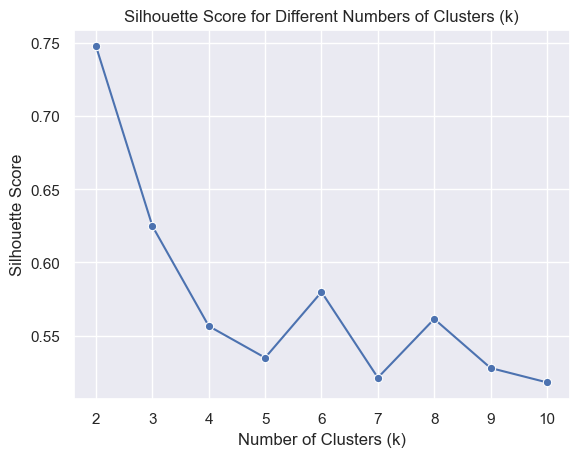

In [76]:
from pyspark.ml.clustering import KMeans

features = ['age', 
            'salery',
            'savings',
            'Food_expenses_month',
            'zip_code',
            'other_expenses_month',
            'educaion_years',
            'economic_class',
            'work_sector_int']
assembler = VectorAssembler(inputCols=features, outputCol="features")

df_vector = assembler.transform(dfc)

def run_kmeans(df, k):
    kmeans = KMeans(k=k, seed=1)
    model = kmeans.fit(df)
    predictions = model.transform(df)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    return silhouette, predictions

silhouettes = []
for k in range(2, 11):  
    silhouette, predictions = run_kmeans(df_vector, k)
    silhouettes.append((k, silhouette))

silhouettes_df = pd.DataFrame(silhouettes, columns=['k', 'silhouette'])

sns.lineplot(data=silhouettes_df, x='k', y='silhouette', marker='o', color='b')
plt.title('Silhouette Score for Different Numbers of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)

בחרתי לחלק את הנתונים ל 4 קלסטרים מכיוון שהשבירה הכי גדולה בגרף מופיעה ב4 קלסטרים ולכן זו החלוקה הכי טובה לנתונים

הכנסתי את החלוקה של הקלסטרים לדטה חדש dfc4

ערך הקלסטר מיוצג בעמודת חיזוי

In [77]:
chosen_k = 4
_, best_predictions = run_kmeans(df_vector, chosen_k)

dfc4 = df_vector.join(best_predictions.select("features", "prediction"), on="features")
dfc4.toPandas().head()

features  educaion_years  \
0  [63.0, 4984.0, 25366.0, 1264.0, 40164.0, 2185....              17   
1  [49.0, 2706.0, 4821.0, 526.0, 38704.0, 1825.0,...              13   
2  [28.0, 8177.0, 13808.0, 1268.0, 38252.0, 1295....              16   
3  [32.0, 3264.0, 7873.0, 393.0, 38244.0, 1509.0,...              15   
4  [48.0, 8103.0, 16390.0, 1138.0, 31396.0, 1601....              14   

   work_sector_int   age  salery  savings  Food_expenses_month  zip_code  \
0              1.0  63.0  4984.0    25366                 1264     40164   
1              4.0  49.0  2706.0     4821                  526     38704   
2              2.0  28.0  8177.0    13808                 1268     38252   
3              4.0  32.0  3264.0     7873                  393     38244   
4              2.0  48.0  8103.0    16390                 1138     31396   

   other_expenses_month  economic_class  prediction  
0                  2185             3.0           3  
1                  1825             1.0           0  
2                  1295             7.0           0  
3                  1509             2.0           0  
4                  1601             7.0           0

In [78]:
dfc4 = dfc4.drop(col("features"))
dfc4.toPandas().head()

educaion_years  work_sector_int   age  salery  savings  \
0              17              1.0  63.0  4984.0    25366   
1              13              4.0  49.0  2706.0     4821   
2              16              2.0  28.0  8177.0    13808   
3              15              4.0  32.0  3264.0     7873   
4              14              2.0  48.0  8103.0    16390   

   Food_expenses_month  zip_code  other_expenses_month  economic_class  \
0                 1264     40164                  2185             3.0   
1                  526     38704                  1825             1.0   
2                 1268     38252                  1295             7.0   
3                  393     38244                  1509             2.0   
4                 1138     31396                  1601             7.0   

   prediction  
0           3  
1           0  
2           0  
3           0  
4           0

ביצעתי מטרית בלבול כדי לבדוק האם לעמודת החיזוי יש קשר לאחד העמודות האחרות 

In [79]:
CorrDF = dfc4.sample(False, 1.0, 46)
vector_features = "features"
assembler = VectorAssembler(inputCols=CorrDF.columns, outputCol=vector_features)
df_vector = assembler.transform(dfc4).select(vector_features)
matrix = Correlation.corr(df_vector, vector_features, 'pearson')
result = matrix.collect()[0]["pearson({})".format(vector_features)].values
reshape_matrix = pd.DataFrame(result.reshape(-1, len(CorrDF.columns)), columns=CorrDF.columns, index=CorrDF.columns)
reshape_matrix

educaion_years  work_sector_int       age    salery  \
educaion_years              1.000000        -0.048160  0.008533  0.665543   
work_sector_int            -0.048160         1.000000 -0.004212  0.089523   
age                         0.008533        -0.004212  1.000000  0.007241   
salery                      0.665543         0.089523  0.007241  1.000000   
savings                     0.517061         0.218975  0.000789  0.724853   
Food_expenses_month         0.625184         0.219469  0.002303  0.827034   
zip_code                    0.001053        -0.007299  0.006338  0.006762   
other_expenses_month       -0.021313        -0.005227  0.014675 -0.019856   
economic_class              0.654044         0.090280  0.005385  0.980158   
prediction                  0.263886        -0.276059  0.002365  0.320407   

                       savings  Food_expenses_month  zip_code  \
educaion_years        0.517061             0.625184  0.001053   
work_sector_int       0.218975             0.219469 -0.007299   
age                   0.000789             0.002303  0.006338   
salery                0.724853             0.827034  0.006762   
savings               1.000000             0.702627  0.024747   
Food_expenses_month   0.702627             1.000000  0.009170   
zip_code              0.024747             0.009170  1.000000   
other_expenses_month -0.018862            -0.016560 -0.006866   
economic_class        0.712296             0.812391  0.010579   
prediction            0.248503             0.242396 -0.397077   

                      other_expenses_month  economic_class  prediction  
educaion_years                   -0.021313        0.654044    0.263886  
work_sector_int                  -0.005227        0.090280   -0.276059  
age                               0.014675        0.005385    0.002365  
salery                           -0.019856        0.980158    0.320407  
savings                          -0.018862        0.712296    0.248503  
Food_expenses_month              -0.016560        0.812391    0.242396  
zip_code                         -0.006866        0.010579   -0.397077  
other_expenses_month              1.000000       -0.167779   -0.007835  
economic_class                   -0.167779        1.000000    0.312361  
prediction                       -0.007835        0.312361    1.000000

<Axes: >

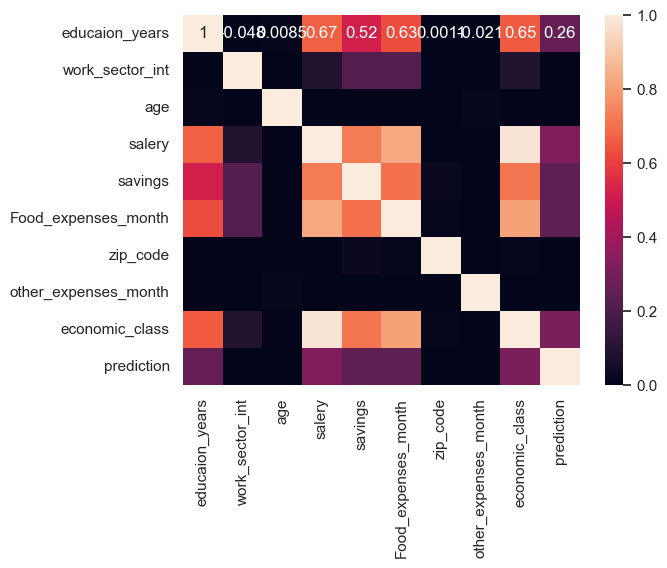

In [80]:
sns.heatmap(reshape_matrix, vmin=0, vmax=1, annot=True)

כפי שניתן לראות קיימים קשרים יחסית חלשים לעמודות משכורת , מצב כלכלי , שנות לימוד ,חסכונות והוצאות אוכל

C:\Users\firem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\firem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\firem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\firem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

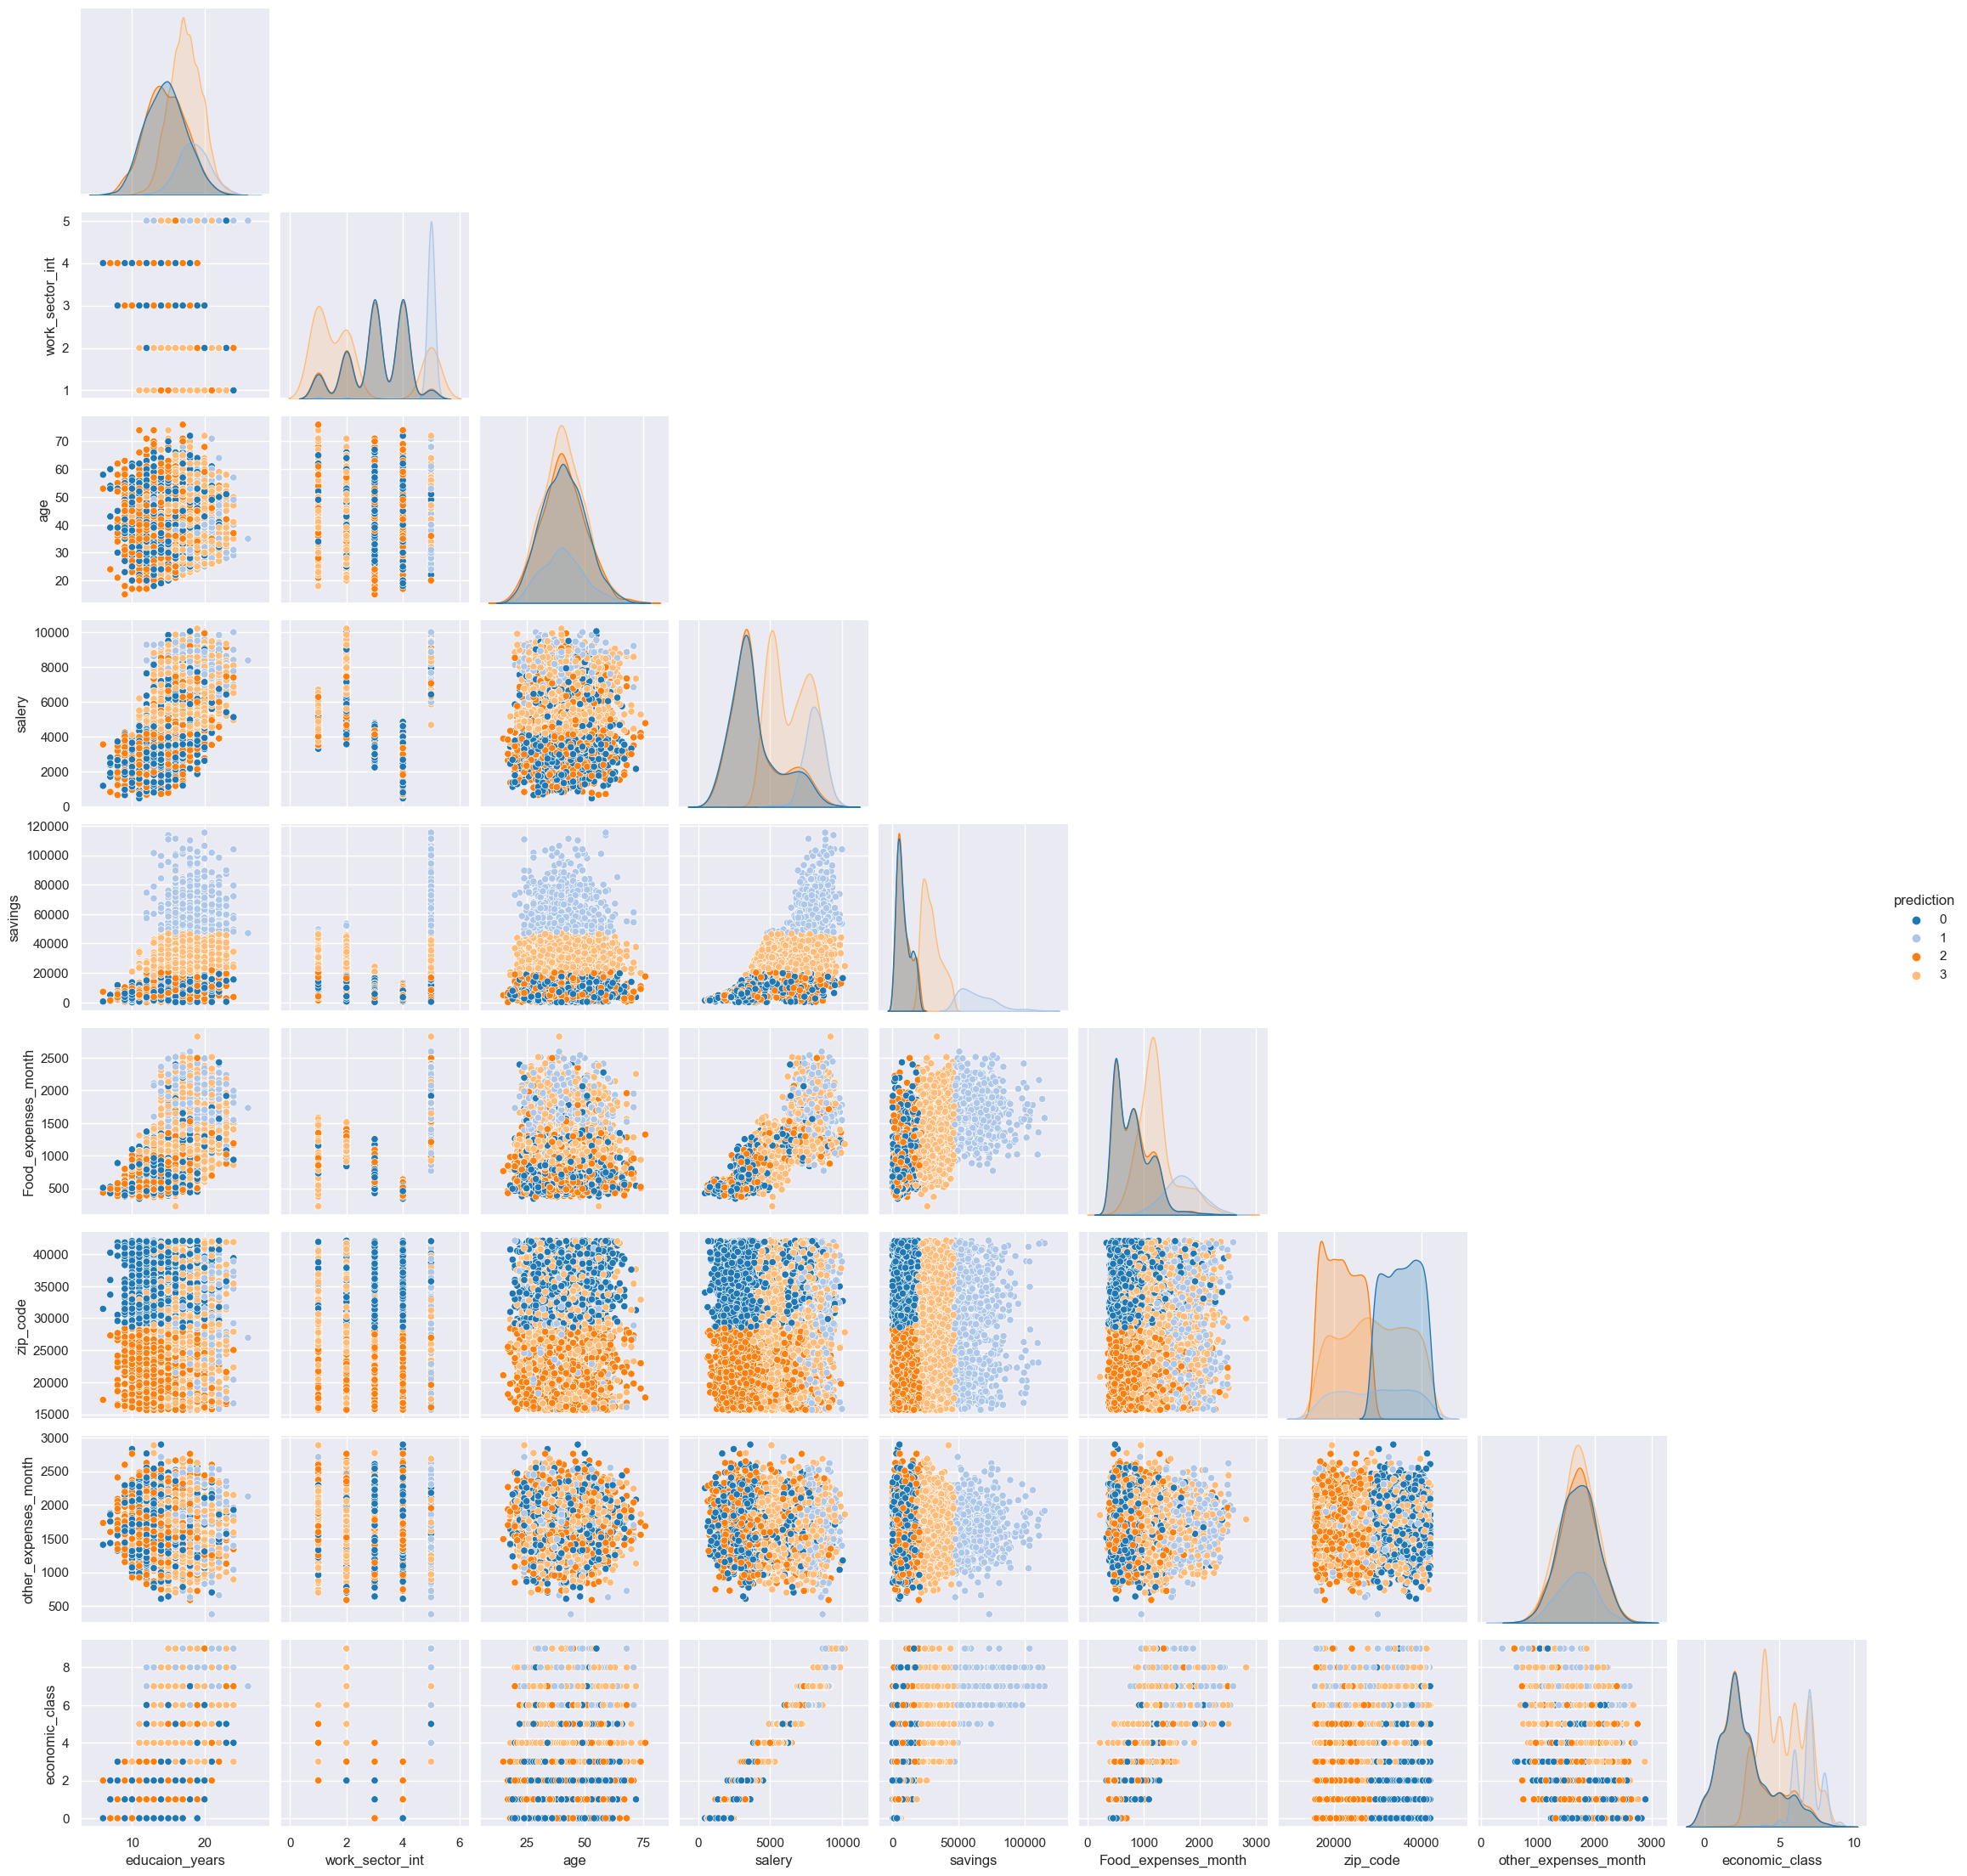

In [81]:
sns.pairplot(dfc4.toPandas(), hue='prediction', palette='tab20', corner=True)

ניתן בסוף לראות לאחר בחירת כמות הקלסטרים את הפיזור של כל הקלסטרים ביחס לכל זוג עמודות

ניתן לראות שהעמודה בה הפיזור הינו אופטימלי הינה עמודת חיסכון מול כל העמודות האחרות

קיים פיזור ברור אם כי במידה מועטה יותר גם בין עמודת המיקוד לבין מרבית העמודות האחרות , למרות שזה קצת פחות צפוי

יתכן וזה מעיד על קשר בין מקום המגורים לבין יתר הנתונים אך זה פחות סביר ולכן לא אתיחס לנושא זה בהמשך

**שאילתה שנייה**

**קשר בין מצב אקונומי לסקטור עבודה**

In [82]:
dfc4.groupBy("economic_class", "work_sector_int").count().orderBy("economic_class", "work_sector_int").toPandas()

economic_class  work_sector_int  count
0              0.0              3.0      1
1              0.0              4.0    196
2              1.0              3.0     73
3              1.0              4.0    543
4              2.0              1.0     12
5              2.0              2.0      1
6              2.0              3.0    708
7              2.0              4.0    390
8              3.0              1.0    354
9              3.0              2.0     19
10             3.0              3.0    402
11             3.0              4.0     71
12             3.0              5.0      1
13             4.0              1.0    656
14             4.0              2.0    121
15             4.0              3.0     17
16             4.0              5.0      2
17             5.0              1.0    145
18             5.0              2.0    370
19             5.0              5.0     60
20             6.0              1.0      4
21             6.0              2.0    398
22             6.0              5.0    372
23             7.0              2.0    247
24             7.0              5.0    564
25             8.0              2.0     55
26             8.0              5.0    190
27             9.0              2.0      8
28             9.0              5.0     14

Text(47.25, 0.5, 'Economic Class')

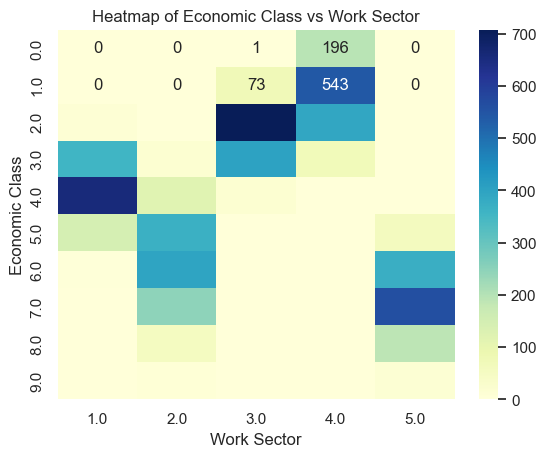

In [83]:
ec_ws = dfc4.groupBy("work_sector_int", "economic_class").count().orderBy("economic_class", "work_sector_int").toPandas()
ec_ws = ec_ws.pivot_table(index="economic_class", columns="work_sector_int", values="count", fill_value=0)
sns.heatmap(ec_ws, annot=True, fmt=".0f", cmap="YlGnBu", cbar=True)
plt.title("Heatmap of Economic Class vs Work Sector")
plt.xlabel("Work Sector")
plt.ylabel("Economic Class")

תיתן לראות שכל אחד מהסקטורים מתרכז במצבים כלכלים מסוימים

סקטור 1 מתרכז בקבוצות 3 ו 4

סקטור 2 מתרכז בקבוצות 5 , 6 ו 7

סקטור 3 מתרכז בקבוצות 2 ו 3

סקטור 4 מתרכז בקבוצות 1 , 2 ו 3

סקטור 5 מתרכז בקבוצות 6 , 7 ו 8

המסקנה היא שלכל סקטור יש עובדים במצב כלכלי שונה בצורה מובהקת

**שאילתה שלישית**

**עלות ממוצעת של עובד לחודש לכל סקטור**

הנחת עבודה - עלות לעובד כוללת משכורת , הוצאות אוכל והוצאות אחרות

In [84]:
total_cost = dfc4.withColumn("total_cost", col("salery") + col("Food_expenses_month") + col("other_expenses_month"))
total_cost = total_cost.groupBy("work_sector_int").agg(
    avg("total_cost").alias("average_total_cost"),
    sum("total_cost").alias("total_sum_cost")
).orderBy("work_sector_int")
total_cost = total_cost
total_cost.toPandas()

work_sector_int  average_total_cost  total_sum_cost
0              1.0         7715.073437    9.034351e+06
1              2.0         9886.200786    1.205128e+07
2              3.0         6006.294033    7.213559e+06
3              4.0         4713.358143    5.656030e+06
4              5.0        11332.732642    1.363328e+07

Text(0, 0.5, 'Average Total Cost')

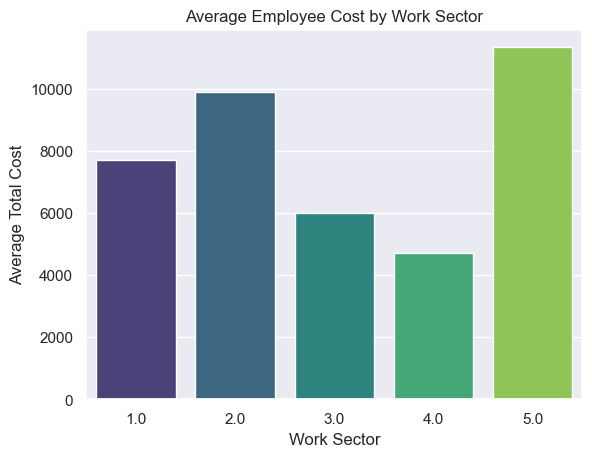

In [85]:
tc = total_cost.toPandas()
sns.barplot(data=tc, x="work_sector_int", y="average_total_cost" ,palette="viridis")
plt.title("Average Employee Cost by Work Sector")
plt.xlabel("Work Sector")
plt.ylabel("Average Total Cost")

ניתן לראות שסקטור עבודה 4 עולה לחברה הכי פחות וסקטור עבודה 5 עולה הכי הרבה לחברה

בנוסף ניתן לרות שמספר הסקטור לא מעיד על משמעותו לפחות בהבטי שכר

**שאילתה רביעית**

**התפלגות העובדים לפי סקטור עבודה**

In [86]:
dispersion_sector = dfc4.groupBy('work_sector_int').count().orderBy('work_sector_int').toPandas()
dispersion_sector

work_sector_int  count
0              1.0   1171
1              2.0   1219
2              3.0   1201
3              4.0   1200
4              5.0   1203

Text(0.5, 1.0, 'Count of Each work_sector_int')

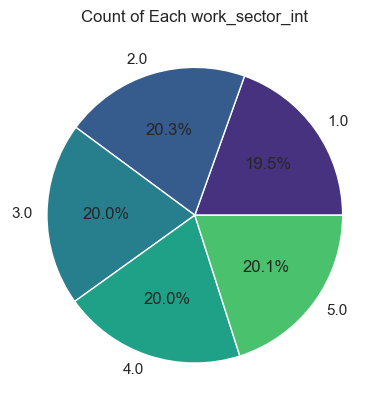

In [87]:
sns.set_palette("viridis")
plt.pie(dispersion_sector['count'], labels=dispersion_sector['work_sector_int'], autopct='%1.1f%%')
plt.title('Count of Each work_sector_int')

אפשר לראות שכל הסקטורים מתפלגים באופן אחיד מה שאומר שכל אחד מהסקטורים מכיל בקירוב אותו מספר עובדים

**שאילתה חמישית**

**ניתוח משכורות העובדים לפי שנות לימוד**

In [88]:
educaion_years_salery = dfc4.groupBy("educaion_years").agg(
    avg("salery").alias("average_salary"),
    percentile_approx("salery", 0.5).alias("median_salary"),
    percentile_approx("salery", 0.25).alias("first_quartile"),
    percentile_approx("salery", 0.75).alias("third_quartile"),
    coalesce(stddev("salery"), F.lit(0)).alias("salary_stddev")
).toPandas()
educaion_years_salery

educaion_years  average_salary  median_salary  first_quartile  \
0               26     8377.000000         8377.0          8377.0   
1               12     2990.013142         2978.0          2293.0   
2               22     7500.123288         7636.0          6985.0   
3               13     3373.645139         3261.0          2505.0   
4               16     5386.197760         5147.0          3658.0   
5                6     2383.000000         1199.0          1199.0   
6               20     7083.281501         7382.0          6236.0   
7               19     6794.103536         7080.0          5604.0   
8               15     4594.459259         4163.0          3280.0   
9               17     5994.315149         5782.0          4702.0   
10               9     2654.500000         2711.0          2140.0   
11               8     2451.200000         2349.0          1679.0   
12              23     7761.771429         7806.0          7462.0   
13               7     2034.833333         1932.0          1725.0   
14              10     2606.430409         2607.0          2144.0   
15              24     7482.142857         7401.0          6684.0   
16              21     7323.763017         7505.0          6645.0   
17              11     2814.521008         2785.0          2191.0   
18              14     4004.788430         3561.0          2907.0   
19              18     6502.173529         6863.0          5155.0   

    third_quartile  salary_stddev  
0           8377.0       0.000000  
1           3602.0    1094.940936  
2           8362.0    1234.844085  
3           3842.0    1355.743140  
4           7062.0    1905.745468  
5           3567.0    1674.428858  
6           8126.0    1392.996719  
7           7945.0    1501.383237  
8           5563.0    1826.482022  
9           7541.0    1814.644443  
10          3221.0     804.217405  
11          3207.0     887.239100  
12          8497.0     968.499539  
13          2490.0     700.794811  
14          3161.0     727.741734  
15          8408.0    1426.259598  
16          8137.0    1165.670101  
17          3430.0     905.331120  
18          4765.0    1704.182909  
19          7894.0    1671.858996

Text(0, 0.5, 'Average Salary')

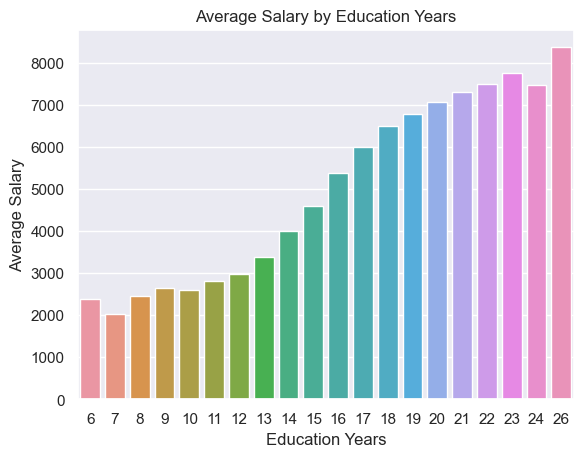

In [89]:
sns.barplot(x='educaion_years', y='average_salary', data=educaion_years_salery)
plt.title('Average Salary by Education Years')
plt.xlabel('Education Years')
plt.ylabel('Average Salary')

ניתן לראות מאוד בבירור שככל שלומדים יותר המשכורת עולה בהתאמה

ניתן לראות כי במרבית המקרים החציון והממוצע קרובים מה שמראה על התפלגות נורמלית

בנוסף ניתן לראות כי סטיית הטקן יחסית גבוה מה שמראה שהפיזור מאוד רחב

**שאילתה שישית**

**ממצוע חיסכון לפי מצב כלכלי**

In [90]:
economic_class_column = "economic_class"
savings_column = "savings"
economic_class_savings = dfc4.groupBy(economic_class_column).agg(
    min(savings_column).alias("min_savings"),
    max(savings_column).alias("max_savings"),
    avg(savings_column).alias("avg_savings")
).orderBy("avg_savings").toPandas()
economic_class_savings

economic_class  min_savings  max_savings   avg_savings
0             0.0          544         6537   3103.147208
1             1.0          282        18606   4783.400974
2             2.0           23        26098   6770.756976
3             3.0            9        47182  14265.076741
4             5.0          260        74809  23017.149565
5             4.0          108        49536  24244.850503
6             6.0          106        98349  32005.350129
7             7.0          386       115359  41068.050555
8             9.0        10830       103977  44610.545455
9             8.0         1174       113621  47986.942857

C:\Users\firem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\firem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\firem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\firem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

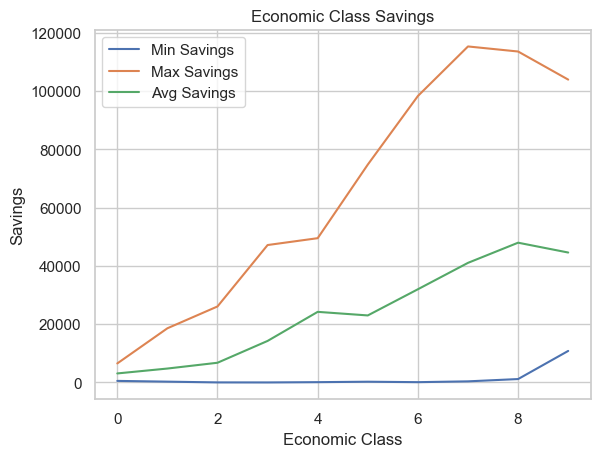

In [91]:
sns.set(style="whitegrid")

sns.lineplot(data=economic_class_savings, x=economic_class_column, y='min_savings', label='Min Savings')
sns.lineplot(data=economic_class_savings, x=economic_class_column, y='max_savings', label='Max Savings')
sns.lineplot(data=economic_class_savings, x=economic_class_column, y='avg_savings', label='Avg Savings')

plt.title('Economic Class Savings')
plt.xlabel('Economic Class')
plt.ylabel('Savings')
plt.legend()

ניתן לראות שככלל עליה במצב הכלכלי מגדילה את החיסכון

בכל מגב כלכלי קימים עובדים שלא חוסכים כלל

כמו חן רואים ברמות הגבהות של מצב כלכלי קיימת דווקא ירידה מסוימת בחיסכון

**Use Case**

החברה עומדת בפני גידול של כ 20% בשנה הקרובה

במקביל יש תהלך של הצערת החברה וכל מי שמבוגר מגיל 60 יצא לפנסה

החברה רוצה שיהיה אנשים יותר משכילים ולכן היא דורשת שלכל העובדים בחזרה יהיה לפחות תואר ראשון כלומר 16 שנות לימוד

רוצים להערך ולחזות את התוספת בעלות ההעסקה של עובדים 

הנחת עבודה - עלות התעסוקה של עובדים מחושבת לפי סכום המשכורת , הוצאות אוכל והוצאות נוספות

לצורך החישוב נסיר תחילה את כל העובדים שאינים עומדים בקריטריונים החדשים

In [92]:
dfuc = dfc.filter((col("educaion_years") >= 16) & (col("age") <= 60))
dfuc.toPandas().head()

educaion_years  work_sector_int   age  salery  savings  \
0              20              2.0  38.0  6761.0    30433   
1              22              5.0  41.0  7776.0    63653   
2              18              1.0  47.0  4209.0    24310   
3              16              2.0  41.0  8142.0    29707   
4              17              1.0  34.0  3845.0    25929   

   Food_expenses_month  zip_code  other_expenses_month  economic_class  
0                 1089     21107                  1652             6.0  
1                 2057     17614                  1740             7.0  
2                  965     19128                  2030             3.0  
3                 1224     26651                  1993             7.0  
4                  903     16984                  1073             3.0

In [93]:
dfuc.toPandas().describe()

educaion_years  work_sector_int          age        salery  \
count     3370.000000      3370.000000  3370.000000   3370.000000   
mean        18.008309         2.905935    40.323739   6316.503616   
std          1.720769         1.601534     8.370888   1796.738252   
min         16.000000         1.000000    21.000000   1195.000000   
25%         17.000000         2.000000    34.000000   4934.000000   
50%         18.000000         2.000000    40.000000   6620.500000   
75%         19.000000         5.000000    46.000000   7813.000000   
max         26.000000         5.000000    60.000000  10194.000000   

             savings  Food_expenses_month      zip_code  other_expenses_month  \
count    3370.000000          3370.000000   3370.000000           3370.000000   
mean    28511.976261          1247.943027  28766.655786           1703.826706   
std     19522.719817           406.574781   7699.596463            331.222948   
min        54.000000           223.000000  15620.000000            378.000000   
25%     14843.000000           977.250000  22079.750000           1485.000000   
50%     24196.000000          1194.000000  28725.500000           1714.000000   
75%     37127.500000          1458.000000  35475.250000           1926.000000   
max    115359.000000          2826.000000  42119.000000           2757.000000   

       economic_class  
count     3370.000000  
mean         5.110386  
std          1.854530  
min          0.000000  
25%          4.000000  
50%          5.000000  
75%          7.000000  
max          9.000000

לאחר הסינון נוטרו 3370 עובדים

התחלנו עם 5994 עובדים ולאחר תוספרת של 20% אנחנו אמורים להגיע לכ 7200 עובדים

כלומר חסרים לנו 3830 עובדים שצריכים לעמוד בקריטריונים החדשים

נדרש לבצע חיצוי של סקטור עבודה של העובדים החדשים

כפי שפוט בהרחבה בסעיף 1 הדרך המיטבית לחיזוי סקטור עבודה היא שימוש במודל רנדום פורסט

מתוך העובדים שעומדים בקריטריונים ניקח 20% לטובת אימון ו 80% חיזוי 

In [94]:
feature_columns = ['economic_class','age', 'salery', 'savings', 'Food_expenses_month', 'zip_code', 'other_expenses_month',
                      'educaion_years']
assembler = VectorAssembler(inputCols=feature_columns,outputCol="features")
data_vector = assembler.transform(dfuc)
dfuc = assembler.transform(dfuc)
data_vector.toPandas().head()

educaion_years  work_sector_int   age  salery  savings  \
0              17              1.0  39.0  4340.0    18032   
1              24              5.0  31.0  7763.0    57082   
2              16              4.0  60.0  2870.0     6297   
3              17              1.0  44.0  5181.0    13670   
4              18              2.0  49.0  5672.0    22337   

   Food_expenses_month  zip_code  other_expenses_month  economic_class  \
0                 1387     28994                  1093             4.0   
1                 1413     36634                  1365             7.0   
2                  485     17115                  1714             2.0   
3                 1094     40308                  1979             4.0   
4                 1061     16402                  1500             5.0   

                                            features  
0  [4.0, 39.0, 4340.0, 18032.0, 1387.0, 28994.0, ...  
1  [7.0, 31.0, 7763.0, 57082.0, 1413.0, 36634.0, ...  
2  [2.0, 60.0, 2870.0, 6297.0, 485.0, 17115.0, 17...  
3  [4.0, 44.0, 5181.0, 13670.0, 1094.0, 40308.0, ...  
4  [5.0, 49.0, 5672.0, 22337.0, 1061.0, 16402.0, ...

In [95]:
(train, test) = dfuc.randomSplit([0.2,0.8], seed =2020)
print("train #: " + str(train.count()),"test#: " + str(test.count()))

train #: 702 test#: 2668


In [96]:
from pyspark.ml.classification import RandomForestClassifier
RF = RandomForestClassifier(featuresCol = 'features', labelCol = 'work_sector_int')
RFModel = RF.fit(train)
RF_predictions = RFModel.transform(test)
RF_predictions.toPandas().head()

educaion_years  work_sector_int   age  salery  savings  \
0              16              1.0  21.0  4509.0    22817   
1              16              1.0  21.0  5424.0    22076   
2              16              1.0  23.0  4924.0    21279   
3              16              1.0  24.0  4269.0    15741   
4              16              1.0  24.0  4495.0    31170   

   Food_expenses_month  zip_code  other_expenses_month  economic_class  \
0                  946     26124                  1485             4.0   
1                 1185     19228                  1832             4.0   
2                 1089     35911                  2255             3.0   
3                  827     32519                  2182             3.0   
4                 1211     26189                  2018             3.0   

                                            features  \
0  [4.0, 21.0, 4509.0, 22817.0, 946.0, 26124.0, 1...   
1  [4.0, 21.0, 5424.0, 22076.0, 1185.0, 19228.0, ...   
2  [3.0, 23.0, 4924.0, 21279.0, 1089.0, 35911.0, ...   
3  [3.0, 24.0, 4269.0, 15741.0, 827.0, 32519.0, 2...   
4  [3.0, 24.0, 4495.0, 31170.0, 1211.0, 26189.0, ...   

                                       rawPrediction  \
0  [0.0, 18.679700396496152, 0.9508589539905697, ...   
1  [0.0, 15.564538564390455, 4.390008890746626, 0...   
2  [0.0, 18.485666211388626, 1.429056131459483, 0...   
3  [0.0, 17.205729763564538, 1.4222043238633213, ...   
4  [0.0, 17.79256907235097, 2.1808463073144133, 0...   

                                         probability  prediction  
0  [0.0, 0.9339850198248076, 0.047542947699528486...         1.0  
1  [0.0, 0.7782269282195227, 0.21950044453733125,...         1.0  
2  [0.0, 0.9242833105694311, 0.07145280657297413,...         1.0  
3  [0.0, 0.8602864881782268, 0.07111021619316607,...         1.0  
4  [0.0, 0.8896284536175483, 0.10904231536572062,...         1.0

In [97]:
evaluator = MulticlassClassificationEvaluator(labelCol="work_sector_int", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(RF_predictions)
print("Accuracy:", accuracy)

Accuracy: 0.9145427286356822


כמו שניתן לראות המודל מדוייק במידה של 91%

In [98]:
RF_predictions = RF_predictions.withColumnRenamed("prediction", "work_sector_prediction")
dfuc = RF_predictions.drop("features", "rawPrediction", "probability")
dfuc.toPandas().head()

educaion_years  work_sector_int   age  salery  savings  \
0              16              1.0  21.0  4509.0    22817   
1              16              1.0  21.0  5424.0    22076   
2              16              1.0  23.0  4924.0    21279   
3              16              1.0  24.0  4269.0    15741   
4              16              1.0  24.0  4495.0    31170   

   Food_expenses_month  zip_code  other_expenses_month  economic_class  \
0                  946     26124                  1485             4.0   
1                 1185     19228                  1832             4.0   
2                 1089     35911                  2255             3.0   
3                  827     32519                  2182             3.0   
4                 1211     26189                  2018             3.0   

   work_sector_prediction  
0                     1.0  
1                     1.0  
2                     1.0  
3                     1.0  
4                     1.0

פה ניתן לראות את פיזור המדגם שמדמה את הפיזור ערכי הסקטור במבנה החדש של החברה

In [99]:
dispersion_sector_n = dfuc.groupBy('work_sector_prediction').count().orderBy('work_sector_prediction')
dispersion_sector_n.toPandas()

work_sector_prediction  count
0                     1.0    640
1                     2.0    835
2                     3.0    284
3                     4.0     73
4                     5.0    836

Text(0.5, 1.0, 'Count of Each work_sector')

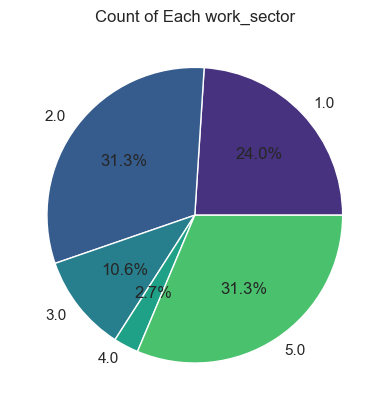

In [100]:
dsn = dispersion_sector_n.toPandas()
sns.set_palette("viridis")
plt.pie(dsn['count'], labels=dsn['work_sector_prediction'], autopct='%1.1f%%')
plt.title('Count of Each work_sector')

לעומת המצב הקודם בו פיזור הסקטורים היה אחיד פה יש שינוי משמעותי

ניתן לראות שסקטורים 3 ו 4 הצטמצמו מאוד וכן שסקטורים 1 , 2 ו 5 גדלו כתוצאה מהשינוי

פה לקחתי את הממוצאים החדשים והסכימה הכוללת של המשכורת , הוצאות האוכל והוצאות אחרות של המדגם

In [101]:
total_cost_n = dfuc.withColumn("total_cost", col("salery") + col("Food_expenses_month") + col("other_expenses_month"))
total_cost_n = total_cost_n.groupBy("work_sector_prediction").agg(
    avg("total_cost").alias("average_total_cost"),
    sum("total_cost").alias("total_sum_cost")
).orderBy("work_sector_prediction")
total_cost_n = total_cost_n
total_cost_n.toPandas()

work_sector_prediction  average_total_cost  total_sum_cost
0                     1.0         7729.328944    4.946771e+06
1                     2.0         9918.228453    8.281721e+06
2                     3.0         5977.292488    1.697551e+06
3                     4.0         4768.013699    3.480650e+05
4                     5.0        11360.720537    9.497562e+06

Text(0, 0.5, 'Average Total Cost')

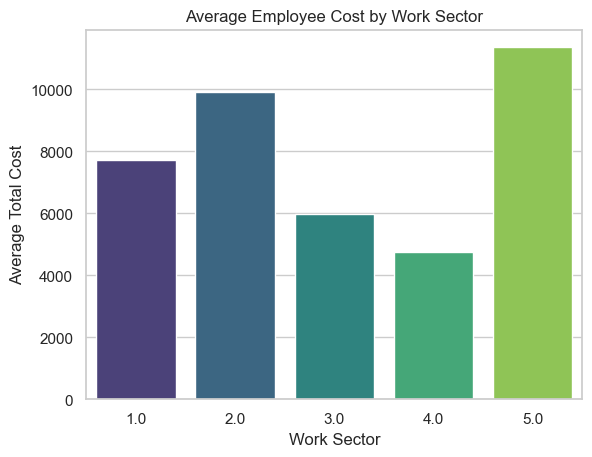

In [102]:
tcn = total_cost_n.toPandas()
sns.barplot(data=tcn, x="work_sector_prediction", y="average_total_cost" ,palette="viridis")
plt.title("Average Employee Cost by Work Sector")
plt.xlabel("Work Sector")
plt.ylabel("Average Total Cost")

כמו שניתן לראות העלויות הממוצעות לעובד של כל אחד מסקטור לא השתנו יותר מדי מהמצב המקורי

In [103]:
total_cost_sector = dispersion_sector_n.join(total_cost_n, on="work_sector_prediction", how="inner")
total_cost_sector.toPandas()

work_sector_prediction  count  average_total_cost  total_sum_cost
0                     1.0    640         7729.328944    4.946771e+06
1                     4.0     73         4768.013699    3.480650e+05
2                     3.0    284         5977.292488    1.697551e+06
3                     2.0    835         9918.228453    8.281721e+06
4                     5.0    836        11360.720537    9.497562e+06

In [104]:
total_cost_sector = total_cost_sector.withColumnRenamed("count", "count_employees")
total_cost_sector.toPandas()

work_sector_prediction  count_employees  average_total_cost  total_sum_cost
0                     1.0              640         7729.328944    4.946771e+06
1                     4.0               73         4768.013699    3.480650e+05
2                     3.0              284         5977.292488    1.697551e+06
3                     2.0              835         9918.228453    8.281721e+06
4                     5.0              836        11360.720537    9.497562e+06

בדיקה של כמות העובדים של המדגם

In [105]:
total_cost_sector.select(sum('count_employees')).collect()[0][0]

2668

בדיקה של אחוז התוספת שצריך בכדי לראות את אחוז הצמיחה עם 7200 עובדים

In [106]:
7200/2668

2.6986506746626686

הוספת מספר עובדים בהכפלה של 2.7 והוצאת מספר שלם וכנגזרת מכך בדקה של העלות הכוללת על ידי הכפלת עלות ממוצעת לעובד והכפלה בכמות העובדים שיצא לאחר השינוי

In [107]:
from pyspark.sql.functions import round, col
total_cost_sector = total_cost_sector.withColumn("Number_employees", round(col("count_employees") * 2.7, scale=0))
total_cost_sector = total_cost_sector.withColumn("cost_sum", round(col("Number_employees") * col("average_total_cost")))
total_cost_sector.toPandas()

work_sector_prediction  count_employees  average_total_cost  \
0                     1.0              640         7729.328944   
1                     4.0               73         4768.013699   
2                     3.0              284         5977.292488   
3                     2.0              835         9918.228453   
4                     5.0              836        11360.720537   

   total_sum_cost  Number_employees    cost_sum  
0    4.946771e+06            1728.0  13356280.0  
1    3.480650e+05             197.0    939299.0  
2    1.697551e+06             767.0   4584583.0  
3    8.281721e+06            2255.0  22365605.0  
4    9.497562e+06            2257.0  25641146.0

In [108]:
total_cost_sector.select(F.sum("Number_employees")).collect()[0][0]

7204.0

עלות קודמת של כלל העובדים בחדרה

In [113]:
old_cost = total_cost.select(sum('total_sum_cost')).collect()[0][0]
old_cost

47588496.026233256

בדיקה עלות של צמיחה של 20% ללא השינוים בהרכב כוח האדם

In [115]:
oc = old_cost*1.2
oc

57106195.231479906

עלות החדשה לאחר השינוים של העובים בחברה

In [116]:
new_cost = new_cost = total_cost_sector.select(sum('cost_sum')).collect()[0][0]
new_cost

66886913.0

ההפרש בין העלות הישנה לחדשה של העובדים

In [117]:
difference = new_cost - oc
difference

9780717.768520094

לסיכום עלות השכר המקורית הייתה לחודש הייתה כ 47.5 מיליון

במידה והחברה הייתה גדלה ב 20% ללא שינוי הרכב כוח האדם העלות הייתה כ 57 מיליון

במצב החדש העלות הכוללת הינה כ 67 מיליון

מצב זה יקר בכ 19 מיליון המהבים גידול של 41% מול המצב המקורי

מצב זה יקר בכ 10 מיליון המהבים גידול של 17% מול גידול של 20% בחברה ללא שינוי בהרכב כוח האדם

נתונים אלה יוכלים להפשר להנהלה לקבל החלטה מושכלת לגבי מיבוע השינוי